** Various tests for C LALSuite implementation of the surrogate **

MP 10-12/2017, 03/2018

This version of the notebook tests the surrogate that includes self-spin (quadrupole-monopole terms).

In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.set_printoptions(precision=6, linewidth=110)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import h5py
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline as spline

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import designofexperiment as doe
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import uncertaintysampling as us

import lal
import lalsimulation as LS

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(doe)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(us)

import lalsimulation
reload(lalsimulation)
import lalsimulation as LS

import constants
imp.reload(constants)
from constants import *

__init__: Setting weave cache to /var/folders/8s/kg3qdn9s10v11v8zq2fgf94h0000gn/T/501_python27_compiled/f26702/f26702be568e3c613857548d8158e9baa1c66daf


Run `spline_grids/add_TF2_grids_TEOBv4_sur.py` first to augment the data file.

In [4]:
# The surrogate data file that we will use below
sur_data_file = 'SEOBNRv4T_surrogate_v1.0.0.hdf5'

In [5]:
fp = h5py.File(sur_data_file, 'r')
TF2_Mf_amp_linear = fp['TF2_Mf_amp_linear'][:]
TF2_Mf_amp_cubic = fp['TF2_Mf_amp_cubic'][:]
TF2_Mf_phi_linear = fp['TF2_Mf_phi_linear'][:]
TF2_Mf_phi_cubic = fp['TF2_Mf_phi_cubic'][:]
fp.close()

# Notes

Ben: 
  * data file for my new method of generating surrogates using splines instead of reduced bases. 
  * The class in the gpsurrogate repository that implements this is called `GPSplineSurrogate`: https://github.com/benjaminlackey/gpsurrogate/blob/master/src/surrogate.py#L498
  * Still using `taylorf2_amp_1pn` in https://github.com/benjaminlackey/gpsurrogate/blob/master/src/taylorf2.py#L237
  

Ben: The relevant functions for doing the interpolation are kernel() and gp_predict() found here:
https://github.com/benjaminlackey/gpsurrogate/blob/master/notebooks/EOB/LalsuiteSurrogate.ipynb
They take in arrays and return scalars.

* The output of gp_predict() are the amplitude and phase at the EI nodes
* Dot these into the amplitude and phase bases that should also be in the HDF5 file
* To obtain the waveform need the TF2 waveform: [taylorf2.py](https://github.com/benjaminlackey/gpsurrogate/blob/master/src/taylorf2.py)
* Take a look at the surrogate class: surrogate.py
  - See [reconstruct_amp_phase_difference()](https://github.com/benjaminlackey/gpsurrogate/blob/master/src/surrogate.py#L142)


```
    namp_nodes = len(damp_gp_list)
    nphase_nodes = len(dphase_gp_list)

    # Calculate waveform at nodes
    amp_at_nodes = np.array([damp_gp_list[j].predict(np.atleast_2d(params))[0] for j in range(namp_nodes)])
    phase_at_nodes = np.array([dphase_gp_list[j].predict(np.atleast_2d(params))[0] for j in range(nphase_nodes)])

    # Get complex version of B_j's in array form
    Bamp_j_array = np.array([Bamp_j[j].amp for j in range(namp_nodes)])
    Bphase_j_array = np.array([Bphase_j[j].phase for j in range(nphase_nodes)])

    # Evaluate waveform
    amp_interp = np.dot(amp_at_nodes, Bamp_j_array)
    phase_interp = np.dot(phase_at_nodes, Bphase_j_array)

    # Rewrite as TimeDomainWaveform
    xarr = Bamp_j[0].x
    return wave.Waveform.from_amp_phase(xarr, amp_interp, phase_interp)
```


Also
```
    jmax = len(B_j)
    eps_f_j = np.array([gp_list[j].predict(np.atleast_2d(point), return_std=True)[1][0] 
                        for j in range(jmax)])
    
    # Get complex version of B_j's in array form
    if data=='amp':
        B_j_array = np.array([B_j[j].amp for j in range(jmax)])
    elif data=='phase':
        B_j_array = np.array([B_j[j].phase for j in range(jmax)])
    else:
        raise Exception

    # Evaluate waveform
    error_arr = np.dot(eps_f_j, B_j_array)

    # Rewrite as TimeDomainWaveform
    xarr = B_j[0].x
    return xarr, error_arr

```

Check all hdf5 groups and attributes with:

h5dump -n 1 lalsuitetest.hdf5

This prints the description attribute:

h5dump -a description lalsuitetest.hdf5 

# Functions

In [6]:
def kernel(x1, x2, hyperparams):
    """Matern covariance function for n-dimensional data.
    
    Parameters
    ----------
    x1 : array with shape ndim
    x2 : array with shape ndim
    hyperparams : array with shape ndim+2 [sigma_f, ls0, ls1, ..., sigma_n]
        sigma_f : Approximately the range (ymax-ymin) of values that the data takes.
            sigma_f^2 called the signal variance.
        sigma_n : Noise term. The uncertainty in the y values of the data.
        lsi : Length scales for the variation in dimension i.
    
    Returns
    -------
    covariance : float
    """
    sigma_f = hyperparams[0]
    sigma_n = hyperparams[-1]
    ls = hyperparams[1:-1]
    ndim = len(ls)
    
    # Noise nugget for diagonal elements
    if np.array_equal(x1, x2):
        nugget = sigma_n**2
    else:
        nugget = 0.0
    
    # r**2
    rsq = np.sum(np.array([(x1[i]-x2[i])**2 / ls[i]**2 for i in range(ndim)]))
    r = np.sqrt(rsq)
    
    # nu = 5/2 Matern covariance
    matern = (1. + np.sqrt(5.)*r + 5.*r**2/3.) * np.exp(-np.sqrt(5.)*r)
    
    # Full covariance
    # You must include the nugget to agree with scikit-learn when the points x1, x2 are exactly the same
    
#     print "** kernel **"
#     print "x1 =", x1
#     print "x2 =", x2
#     print "ls =", ls
#     print "(x1 - x2) / ls = ", np.array([(x1[i]-x2[i]) / ls[i] for i in range(ndim)])
#     print "r =", r
#     print "eval =", sigma_f**2 * matern + nugget
    
    return sigma_f**2 * matern + nugget

In [7]:
def gp_predict(xst, hyperparams, x_train, Kinv_dot_y):
    """Interpolate the function at the point xst using Gaussian process regression.
    
    Parameters
    ----------
    xst : array of shape ndim.
        Point x_* where you want to evaluate the function.
    hyperparams : array with shape ndim+2 [sigma_f, ls0, ls1, ..., sigma_n].
        Hyperparameters for the GPR kernel.
    x_train : array of shape (n_train, ndim).
        Training set points.
    Kinv_dot_y : array of shape n_train.
        The interpolating weights at each training set point.
    
    Returns
    -------
    yst : float
        Interpolated value at the point xst.
    """
    # Evaluate vector K_*
    Kst = np.array([kernel(xst, x, hyperparams) for x in x_train])
#     print 'Kst', Kst
#     print 'Kinv_dot_y', Kinv_dot_y[:]

    # Evaluate y_*
    return np.dot(Kst, Kinv_dot_y)

In [8]:
def extract_data_from_scikit_learn(gp):
    """Extract the data in the scikit-learn GaussianProcessRegressor class 
    that you need for the lalsuite version.
    """
    # hyperparams = np.array([sigma_f, lq, ls1, ls2, llam1, llam2, sigma_n])
    hyperparams = gpr.get_hyperparameters(gp)
    
    # The training data
    x_train = gp.X_train_
    y_train = gp.y_train_
    
    # Evaluate K
    K = np.array([[kernel(x1, x2, hyperparams) for x2 in x_train] for x1 in x_train])
    
    # Evaluate K^{-1}
    Kinv = np.linalg.inv(K)
    
    # Evaluate (K^{-1})_{ij} y_j (array of length nparams).
    Kinv_dot_y = np.dot(Kinv, y_train)
    
    return hyperparams, x_train, Kinv_dot_y

In [9]:
import taylorf2

def geometric_reference_waveform(params, mf, spin_spin=False):
    """Reference TaylorF2 waveform in geometric units
    evaluated at the same times as the surrogate of the difference.
    """
    q, s1, s2, lambda1, lambda2 = params
    h_ref = taylorf2.dimensionless_taylorf2_waveform(
        mf=mf, q=q,
        spin1z=s1, spin2z=s2,
        lambda1=lambda1, lambda2=lambda2,
        spin_spin=spin_spin)

    # Reference waveform has zero starting phase
    h_ref.add_phase(remove_start_phase=True)
    return h_ref

In [10]:
def TEOB_surrogate_Python_compute_amplitude_phase_corrections(x, mfs, sur_data_file):
    """
    MP assembled this from different pieces of code; want to have geometric frequency as an argument

    Parameters:
        x: 5D parameter space point (q<=1, chi1, chi2, lambda1, lambda2)
        mfs: array of geometric frequencies
    """
    fp = h5py.File(sur_data_file, 'r')

    # Compute amplitude and phase coefficients for an example point
    N_amp = len(fp['spline_nodes_amp'])
    N_phi = len(fp['spline_nodes_phase'])

    # Calculate waveform at nodes
    amp_at_nodes = np.array([gp_predict(x,
                                        fp['hyp_amp'][i], 
                                        fp['x_train'], 
                                        fp['kinv_dot_y_amp'][i]) 
                             for i in range(N_amp)])

    phase_at_nodes = np.array([gp_predict(x,
                                          fp['hyp_phi'][i], 
                                          fp['x_train'], 
                                          fp['kinv_dot_y_phi'][i]) 
                               for i in range(N_phi)])

    # In reconstruct_amp_phase_difference_spline():
    # Prepend the point [mf_a, 0] to the phase nodes
    mf_amp = fp['spline_nodes_amp'][:]
    mf_phase = fp['spline_nodes_phase'][:]
    mf_min = mf_amp[0] # Follow definition of mf_a in GPSplineSurrogate constructor
    mf_max = mf_amp[-1]
    #print [mf_min, mf_max]
    mf_phi = np.insert(mf_phase, 0, mf_min)
    phase_at_nodes = np.insert(phase_at_nodes, 0, 0.0)

    # Interpolate dlnamp and dphase at the frequencies mf_amp and mf_p
    ampoff = interpolate.UnivariateSpline(mf_amp, amp_at_nodes, k=3, s=0)
    phaseoff = interpolate.UnivariateSpline(mf_phi, phase_at_nodes, k=3, s=0)

    # Evaluate dlnamp and dphase at the frequencies mfs
    amp_interp = np.array([ampoff(f) if mf_min <= f <= mf_max else -np.inf if f > mf_max else 0.0 for f in mfs])
    phase_interp = np.array([phaseoff(f) if mf_min <= f <= mf_max else 0.0 for f in mfs])
    
    fp.close()
    
    return amp_interp, phase_interp

In [11]:
def TEOB_surrogate_Python(Mtot, x, fHz, sur_data_file):
    Mtot_sec = Mtot * lal.MTSUN_SI
    mfs = fHz * Mtot_sec
    
    # Compute TaylorF2 reference waveform
    h_ref = geometric_reference_waveform(x, mfs, spin_spin=False)
    
    # Evaluate surrogate for amplitude and phase corrections
    amp_interp, phase_interp = TEOB_surrogate_Python_compute_amplitude_phase_corrections(x, mfs, sur_data_file)
    
    # Surrogate of A and \Phi
    h_sur = h_ref.copy()
    h_sur.amp *= np.exp(amp_interp)
    h_sur.phase += phase_interp
    
    return h_sur

In [12]:
# Point exactly in training set:
x_train_point = np.array([3.333333e-01, -4.000000e-01, -4.000000e-01, 1.000000e-01, 1.000000e-01])

# Test point
x_test_point = np.array([1.0/1.5, 0.35, 0.32, 1000.0, 1500.0])

x = x_test_point

# Test code using lalsimulation HDF5 data (new format)

## Compare surrogate amplitude and phase corrections

In [12]:
ll *.hdf5

-rw-r--r--@ 1 mpuer  staff  1188216 Mar 21 12:10 SEOBNRv4T_surrogate_v1.0.0.hdf5
-rw-r--r--@ 1 mpuer  staff   988664 Dec 26 06:03 SEOBNRv4T_surrogate_v1.0.0_noQM.hdf5
-rw-r--r--@ 1 mpuer  staff    69368 Nov  6 06:19 TEOBv4_surrogate.hdf5
-rw-r--r--  1 mpuer  staff     9840 Dec 12 06:45 timing.hdf5


In [13]:
ls -ltr ~/SEOBNR_ROM_DATA/SEOBNRv4T_surrogate_v1.0.0.hdf5

-rw-r--r--@ 1 mpuer  staff  1131608 Jan 25 08:20 /Users/mpuer/SEOBNR_ROM_DATA/SEOBNRv4T_surrogate_v1.0.0.hdf5


In [14]:
%%bash
h5ls ~/SEOBNR_ROM_DATA/SEOBNRv4T_surrogate_v1.0.0.hdf5

chi1_bounds              Dataset {2}
chi2_bounds              Dataset {2}
hyp_amp                  Dataset {40, 7}
hyp_phi                  Dataset {39, 7}
kinv_dot_y_amp           Dataset {40, 1659}
kinv_dot_y_phi           Dataset {39, 1659}
lambda1_bounds           Dataset {2}
lambda2_bounds           Dataset {2}
q_bounds                 Dataset {2}
spline_nodes_amp         Dataset {40}
spline_nodes_phase       Dataset {39}
x_train                  Dataset {1659, 5}


The output of the lalsimulation code has to agree with the output of the code below.

In [20]:
f = h5py.File(sur_data_file, 'r')

File structure:

    'x_train': N_train x 5
    'hyp_amp': N_amp x 7
    'hyp_phi': N_phi x 7
    'kinv_dot_y_amp': N_amp x N_train
    'kinv_dot_y_phase': N_phi x N_train
    'spline_nodes_amp': N_amp
    'spline_nodes_phase': N_phi
    
'hyperparameters' and 'kinv_dot_y' are different for each amplitude and phase gp fit and corresponding to a spline frequency.

In [21]:
# Compute amplitude and phase coefficients for an example point

for i in range(19):
    kinv_dot_y_amp_i = f['kinv_dot_y_amp'][i]
    kinv_dot_y_phi_i = f['kinv_dot_y_phi'][i]
    hyp_amp_i = f['hyp_amp'][i]
    hyp_phi_i = f['hyp_phi'][i]
    print gp_predict(x, hyp_amp_i, f['x_train'], kinv_dot_y_amp_i), gp_predict(x, hyp_phi_i, f['x_train'], kinv_dot_y_phi_i)

0.0003801932695943755 0.002578671907201624
0.00040965653497804233 0.015289097613873537
0.00045768233176946005 0.04067890498254201
0.0005066045339239267 0.08149929943965617
0.0005555505603612176 0.14099802331202227
0.0006091534407040022 0.22298836115805898
0.0006593414161728539 0.3320063865166958
0.0007150913462271591 0.47334905549178075
0.0007643008353666048 0.6532789584844068
0.0008062263769283984 0.8791447073854215
0.0008368242847898166 1.1595755351827393
0.0008486863636747444 1.5047006385502755
0.0008333556821060739 1.9263845782770659
0.0007779192189079076 2.438537679568981
0.0006676489924197782 3.0574528993165586
0.00047346852164675823 3.8022293703543255
0.00016446368280487178 4.695200471622229
-0.0003158709692447914 5.762622209978872
-0.0010525670256527064 7.035429007926723


In [22]:
# Compute amplitude and phase coefficients for an example point

N_amp = len(f['spline_nodes_amp'])
N_phi = len(f['spline_nodes_phase'])
print N_amp, N_phi

# Calculate waveform at nodes
amp_at_nodes = np.array([gp_predict(x,
                                    f['hyp_amp'][i], 
                                    f['x_train'], 
                                    f['kinv_dot_y_amp'][i]) 
                         for i in range(N_amp)])

phase_at_nodes = np.array([gp_predict(x,
                                      f['hyp_phi'][i], 
                                      f['x_train'], 
                                      f['kinv_dot_y_phi'][i]) 
                           for i in range(N_phi)])

40 39


In [23]:
# In reconstruct_amp_phase_difference_spline():
# Prepend the point [mf_a, 0] to the phase nodes
mf_amp = f['spline_nodes_amp'][:]
mf_phase = f['spline_nodes_phase'][:]
mf_min = mf_amp[0] # Follow definition of mf_a in GPSplineSurrogate constructor
mf_phi = np.insert(mf_phase, 0, mf_min)
phase_at_nodes = np.insert(phase_at_nodes, 0, 0.0)

In [24]:
def FD_waveform_generate_direct(Mtot, x, fLow=20.0, fHigh=2048.0, 
                                deltaF=0.1, spline_order=3):
    q = 1.0/x[0]
    chi1 = x[1]
    chi2 = x[2]
    lambda1 = x[3]
    lambda2 = x[4]
    
    phiRef, fRef = 0.0, fLow
    distance, inclination = 1.0, 0.0
    
    m1 = q/(1.0+q)*Mtot
    m2 = 1.0/(1.0+q)*Mtot
    m1SI, m2SI, chi1, chi2, lambda1, lambda2 = m1*lal.MSUN_SI, m2*lal.MSUN_SI, chi1, chi2, lambda1, lambda2
    
    if (spline_order == 1):
        gsl_spline_order = LS.SEOBNRv4TSurrogate_LINEAR
    elif (spline_order == 3):
        gsl_spline_order = LS.SEOBNRv4TSurrogate_CUBIC
    else:
        raise Error
    
    hp, hc = LS.SimIMRSEOBNRv4TSurrogate(phiRef, deltaF, 
                            fLow, fHigh, fRef, 
                            distance, inclination, 
                            m1SI, m2SI, 
                            chi1, chi2,
                            lambda1, lambda2,
                            gsl_spline_order)
    
    fHz = np.arange(hp.data.length)*hp.deltaF
    h = hp.data.data + 1j*hc.data.data
    
    return fHz, h

In [42]:
x_test_point

array([6.666667e-01, 3.500000e-01, 3.200000e-01, 1.000000e+03, 1.500000e+03])

In [25]:
FD_waveform_generate_direct(5, x_test_point, fLow=20.0, fHigh=2048.0, deltaF=0.1, spline_order=3)

(array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 3.2766e+03, 3.2767e+03, 3.2768e+03]),
 array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]))

In [26]:
# Output of `SEOBNRv4T_surrogate` Copied from Terminal (command is at top of next section)
amp_at_nodes_LAL = np.array([0.000380193,
0.000409657,
0.000457682,
0.000506605,
0.000555551,
0.000609153,
0.000659341,
0.000715091,
0.000764301,
0.000806226,
0.000836824,
0.000848686,
0.000833356,
0.000777919,
0.000667649,
0.000473469,
0.000164464,
-0.000315871,
-0.00105257,
-0.00216369,
-0.00387999,
-0.00648767,
-0.0106392,
-0.0174131,
-0.0304694,
-0.0571186,
-0.120075,
-0.278189,
-0.477393,
-0.643667,
-0.795263,
-0.995975,
-1.31769,
-1.81235,
-2.51845,
-3.48219,
-4.83125,
-6.34217,
-7.28203,
-7.6102])

phi_at_nodes_LAL = np.array([0,
0.00257867,
0.0152891,
0.0406789,
0.0814993,
0.140998,
0.222988,
0.332006,
0.473349,
0.653279,
0.879145,
1.15958,
1.5047,
1.92638,
2.43854,
3.05745,
3.80223,
4.6952,
5.76262,
7.03543,
8.5502,
10.351,
12.4897,
15.0339,
18.0716,
21.7148,
26.1248,
31.5991,
38.5322,
47.0471,
57.0601,
68.3457,
80.5866,
93.3053,
105.785,
116.968,
125.386,
128.959,
123.239,
104.219])

In [27]:
print mf_amp
print amp_at_nodes
print amp_at_nodes - amp_at_nodes_LAL

[0.00021  0.000244 0.000283 0.000328 0.000381 0.000442 0.000513 0.000596 0.000691 0.000802 0.000931 0.001081
 0.001255 0.001456 0.00169  0.001961 0.002276 0.002642 0.003066 0.003559 0.004131 0.004794 0.005564 0.006458
 0.007495 0.008699 0.010096 0.011717 0.013599 0.015784 0.018319 0.021261 0.024676 0.028639 0.033239 0.038578
 0.044774 0.051966 0.060313 0.07    ]
[ 3.801933e-04  4.096565e-04  4.576823e-04  5.066045e-04  5.555506e-04  6.091534e-04  6.593414e-04
  7.150913e-04  7.643008e-04  8.062264e-04  8.368243e-04  8.486864e-04  8.333557e-04  7.779192e-04
  6.676490e-04  4.734685e-04  1.644637e-04 -3.158710e-04 -1.052567e-03 -2.163693e-03 -3.879986e-03
 -6.487667e-03 -1.063924e-02 -1.741313e-02 -3.046935e-02 -5.711863e-02 -1.200745e-01 -2.781890e-01
 -4.773930e-01 -6.436674e-01 -7.952635e-01 -9.959752e-01 -1.317694e+00 -1.812349e+00 -2.518454e+00
 -3.482188e+00 -4.831253e+00 -6.342169e+00 -7.282025e+00 -7.610200e+00]
[ 2.695944e-10 -4.650220e-10  3.317695e-10 -4.660761e-10 -4.396388e-

In [28]:
print mf_phi
print phase_at_nodes
print phase_at_nodes - phi_at_nodes_LAL

[0.00021  0.000244 0.000283 0.000328 0.000381 0.000442 0.000513 0.000596 0.000691 0.000802 0.000931 0.001081
 0.001255 0.001456 0.00169  0.001961 0.002276 0.002642 0.003066 0.003559 0.004131 0.004794 0.005564 0.006458
 0.007495 0.008699 0.010096 0.011717 0.013599 0.015784 0.018319 0.021261 0.024676 0.028639 0.033239 0.038578
 0.044774 0.051966 0.060313 0.07    ]
[0.000000e+00 2.578672e-03 1.528910e-02 4.067890e-02 8.149930e-02 1.409980e-01 2.229884e-01 3.320064e-01
 4.733491e-01 6.532790e-01 8.791447e-01 1.159576e+00 1.504701e+00 1.926385e+00 2.438538e+00 3.057453e+00
 3.802229e+00 4.695200e+00 5.762622e+00 7.035429e+00 8.550195e+00 1.035096e+01 1.248971e+01 1.503393e+01
 1.807161e+01 2.171481e+01 2.612484e+01 3.159911e+01 3.853216e+01 4.704705e+01 5.706007e+01 6.834571e+01
 8.058662e+01 9.330534e+01 1.057854e+02 1.169683e+02 1.253855e+02 1.289592e+02 1.232394e+02 1.042193e+02]
[ 0.000000e+00  1.907202e-09 -2.386126e-09  4.982542e-09 -5.603438e-10  2.331202e-08  3.611581e-07
  3.865167

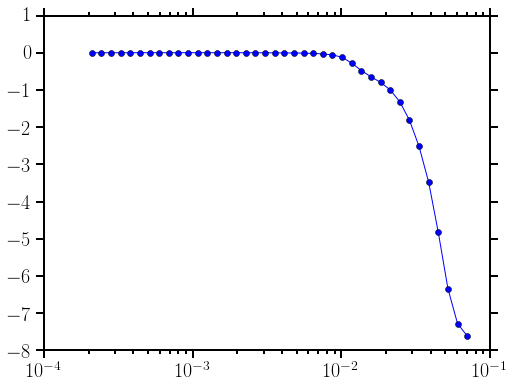

In [29]:
plt.semilogx(mf_amp, amp_at_nodes, 'o-');

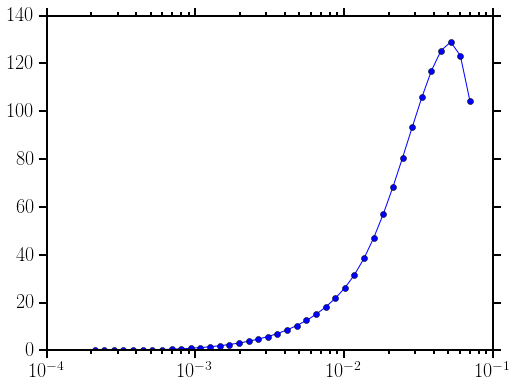

In [30]:
plt.semilogx(mf_phi, phase_at_nodes, 'o-');

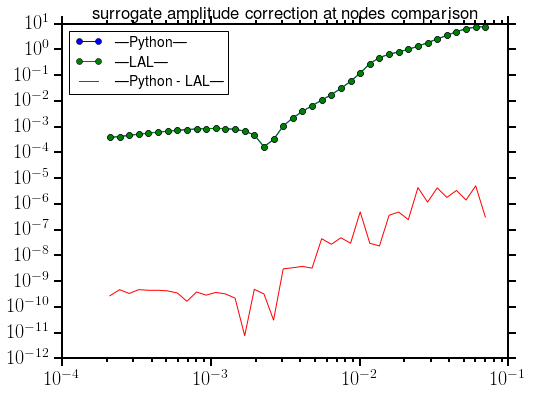

In [31]:
plt.loglog(mf_amp, np.abs(amp_at_nodes), 'o-', label='|Python|')
plt.loglog(mf_amp, np.abs(amp_at_nodes_LAL), 'o-', label='|LAL|')
plt.loglog(mf_amp, np.abs(amp_at_nodes - amp_at_nodes_LAL), label='|Python - LAL|')
plt.legend(loc=2);
plt.title('surrogate amplitude correction at nodes comparison');

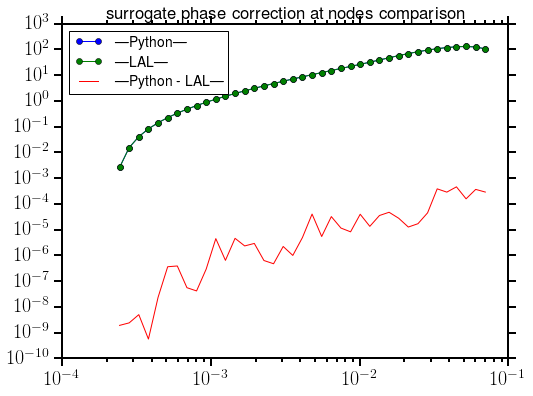

In [32]:
plt.loglog(mf_phi, np.abs(phase_at_nodes), 'o-', label='|Python|')
plt.loglog(mf_phi, np.abs(phi_at_nodes_LAL), 'o-', label='|LAL|')
plt.loglog(mf_phi, np.abs(phase_at_nodes - phi_at_nodes_LAL), label='|Python - LAL|')
plt.legend(loc=2);
plt.title('surrogate phase correction at nodes comparison');

In [33]:
# Interpolate dlnamp and dphase at the frequencies mf_amp and mf_p
ampoff = interpolate.UnivariateSpline(mf_amp, amp_at_nodes, k=3, s=0)
phaseoff = interpolate.UnivariateSpline(mf_phi, phase_at_nodes, k=3, s=0)

In [34]:
# Frequencies for evaluation (only used for testing here)
# Start at approximately 1Hz (mf=1.0e-5) and go up to last spline node
npoints=10000
mfs = np.logspace(-5.0, np.log10(mf_phi[-1]), npoints)

In [35]:
# Evaluate dlnamp and dphase at the frequencies mfs
amp_interp = np.array([ampoff(f) if f>=mf_min else 0.0 for f in mfs])
phase_interp = np.array([phaseoff(f) if f>=mf_min else 0.0 for f in mfs])

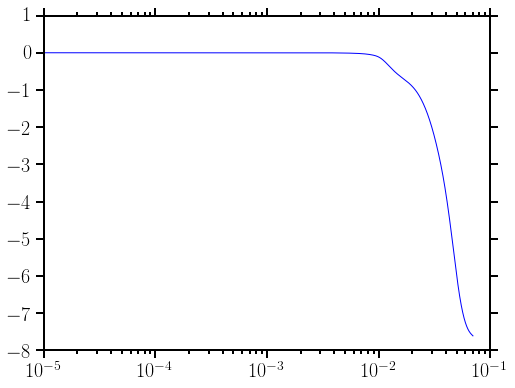

In [36]:
plt.semilogx(mfs, amp_interp);

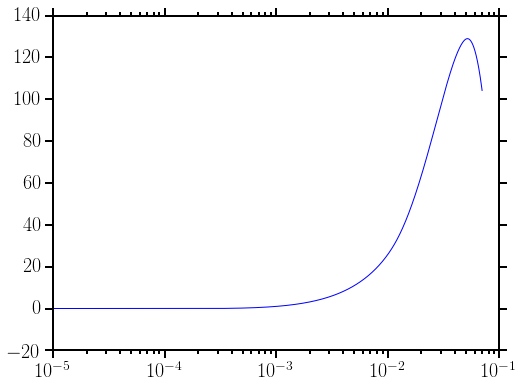

In [37]:
plt.semilogx(mfs, phase_interp);

The code is calling `wave.Waveform.from_amp_phase(mfs, amp_interp, phase_interp)`. This just stores the amplitude and phase in a class.

The complete waveform is reconstructed in `geometric_waveform()`: https://github.com/benjaminlackey/gpsurrogate/blob/master/src/surrogate.py#L559
There, the amplitude and phase corrections are added to the output of `geometric_reference_waveform()`.

```Python
# Surrogate of \Delta\Phi and \Delta\ln A
h_diff_sur = self.amp_phase_difference(params)
# Reference waveform
h_ref = self.geometric_reference_waveform(params)
# Surrogate of A and \Phi
h_sur = h_ref.copy()
h_sur.amp *= np.exp(h_diff_sur.amp)
h_sur.phase += h_diff_sur.phase
```

In [38]:
# Compute TaylorF2 reference waveform
h_ref = geometric_reference_waveform(x, mfs)

In [39]:
# Surrogate of A and \Phi
h_sur = h_ref.copy()
h_sur.amp *= np.exp(amp_interp)
h_sur.phase += phase_interp

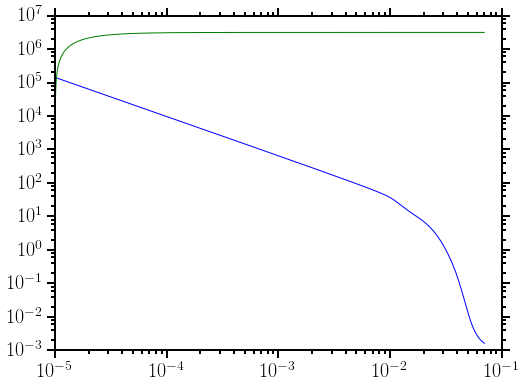

In [40]:
loglog(h_sur.x, h_sur.amp)
loglog(h_sur.x, h_sur.phase)

/usr/local/lib/python2.7/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


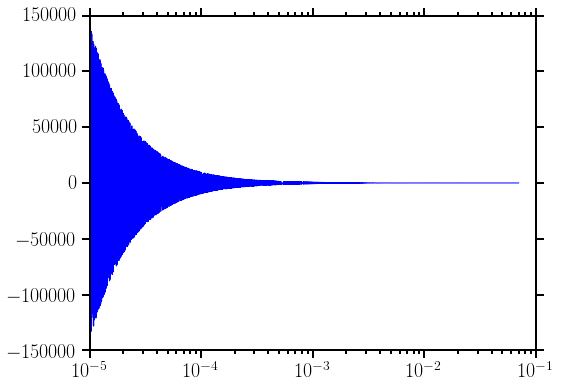

In [41]:
semilogx(h_sur.x, h_sur.amp * np.exp(1j * h_sur.phase))

## Compare TF2 base waveform for zero spin and tides

In [114]:
x = np.array([1.0/1.5, 0.0, 0.0, 0.0, 0.0])

In [115]:
q = 1.0/x[0]
chi1 = x[1]
chi2 = x[2]
lambda1 = x[3]
lambda2 = x[4]

Mtot = 40.0

In [116]:
#TF2_spline_type = LS.SEOBNRv4TSurrogate_LINEAR
TF2_spline_type = LS.SEOBNRv4TSurrogate_CUBIC

In [117]:
phiRef, deltaF, fLow, fHigh, fRef, distance, inclination = 0, 0.1, 20, 0, 20, 1, 0
m1 = q/(1.0+q)*Mtot
m2 = 1.0/(1.0+q)*Mtot
m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max = m1*lal.MSUN_SI, m2*lal.MSUN_SI, chi1, chi2, lambda1, lambda2, -1
hp, hc = LS.SimIMRSEOBNRv4TSurrogate(phiRef, deltaF, fLow, fHigh, fRef, distance, inclination, 
            m1SI, m2SI, chi1, chi2, lambda1, lambda2, TF2_spline_type)

h = hp.data.data + 1j*hc.data.data
fHz = np.arange(hp.data.length)*hp.deltaF

In [118]:
# For comparison generate a TaylorF2 waveform
LALpars = lal.CreateDict()
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1(LALpars, lambda1)
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda2(LALpars, lambda2)

hpTF2 = LS.SimInspiralTaylorF2(phiRef, deltaF,
                                      m1SI, m2SI, 
                                      chi1, chi2,
                                      fLow, fHigh, fRef, distance, LALpars)
# Compute the two polarizations
cfac = cos(inclination)
pfac = 0.5 * (1.0 + cfac**2)

fHzTF2 = np.arange(hpTF2.data.length)*hpTF2.deltaF

hpTF2_data = pfac * hpTF2.data.data
hcTF2_data = -1j*cfac * hpTF2.data.data
hTF2 = hpTF2_data +1j*hcTF2_data

In [121]:
fHz_gt_fLow = fHz[np.where(fHz > fLow)]
h_sur = TEOB_surrogate_Python(Mtot, x, fHz_gt_fLow, sur_data_file)

In [122]:
Mtot_sec = Mtot * lal.MTSUN_SI
mfs = fHz_gt_fLow * Mtot_sec
# Compute TaylorF2 reference waveform
h_ref = geometric_reference_waveform(x, mfs)

In [123]:
f_high = 0.07 / (Mtot * lal.MTSUN_SI)

The amplitude of the surrogate (1PN) will be a bit different from TF2 even if the correction is zero.

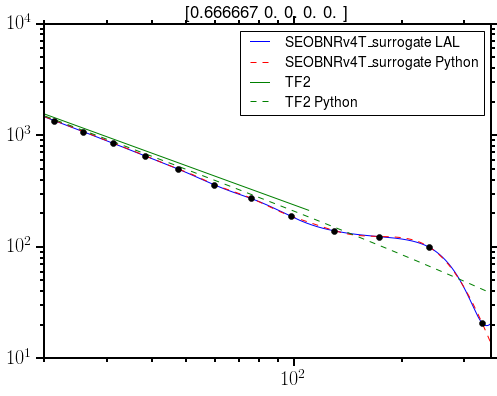

In [124]:
plt.loglog(fHz, np.abs(h), '-', label='SEOBNRv4T\_surrogate LAL')
plt.loglog(fHz_gt_fLow, 11.7*h_sur.amp, 'r--', label='SEOBNRv4T\_surrogate Python')
plt.loglog(fHzTF2, np.abs(hTF2), label='TF2');
plt.loglog(fHz_gt_fLow, 11.7*h_ref.amp, 'g--', label='TF2 Python');

plt.loglog(TF2_Mf_amp_cubic / (Mtot*lal.MTSUN_SI), 
           spline(fHz, np.abs(h), k=3)(TF2_Mf_amp_cubic / (Mtot*lal.MTSUN_SI)), 'ko')

plt.legend(loc=1)
plt.title(x)
plt.xlim([20, f_high]);
plt.ylim([1e1, 1e4]);

The phases agree with TF2 up to where it is computed.

In [125]:
# TF2 phasing used in LAL code
TF2_phi_at_nodes = np.loadtxt('TF2_phi_at_nodes.dat')

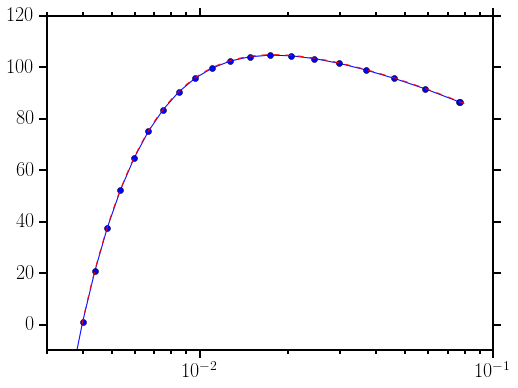

In [126]:
plt.semilogx(TF2_phi_at_nodes.T[0], TF2_phi_at_nodes.T[1] + 65, 'bo-')
plt.semilogx(mfs, h_ref.phase - 0.00*mfs - 0, 'r--', label='TF2 Python');
plt.xlim([3e-3, 1e-1]);
plt.ylim([-10, 120]);

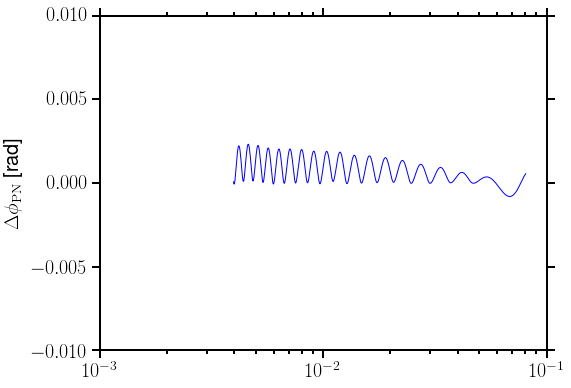

In [127]:
plt.semilogx(mfs, spline(TF2_phi_at_nodes.T[0], TF2_phi_at_nodes.T[1])(mfs) - h_ref.phase + 65.17)
plt.ylim([-0.01, 0.01]);
plt.ylabel(r'$\Delta\phi_\mathrm{PN}$ [rad]');

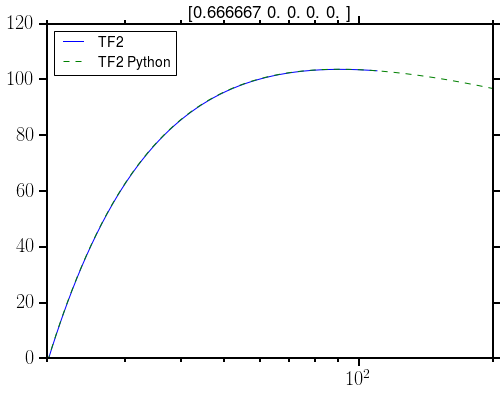

In [128]:
plt.semilogx(fHzTF2, np.unwrap(np.angle(hTF2)), label='TF2');
plt.semilogx(fHz_gt_fLow, h_ref.phase - 0.002*fHz_gt_fLow - 1, 'g--', label='TF2 Python');

plt.legend(loc=2)
plt.title(x)
plt.xlim([20, 200]);
plt.ylim([0, 120]);

So, it looks like the difference at high frequency comes from the correction or how it is being applied / interpolated.

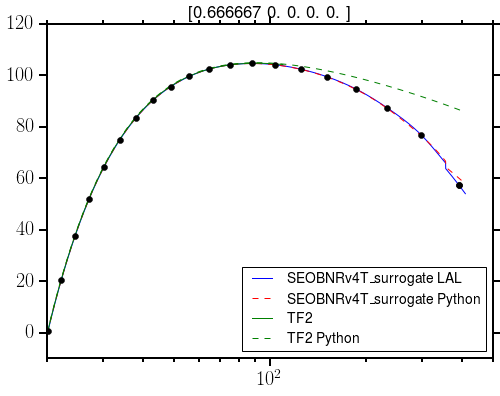

In [169]:
plt.semilogx(fHz, np.unwrap(np.angle(h)) - 0.18*fHz + 2, label='SEOBNRv4T\_surrogate LAL')
plt.semilogx(fHz_gt_fLow, h_sur.phase - 0.068*fHz_gt_fLow , 'r--', label='SEOBNRv4T\_surrogate Python')
plt.semilogx(fHzTF2, np.unwrap(np.angle(hTF2)) + 1, label='TF2');
plt.semilogx(fHz_gt_fLow, h_ref.phase, 'g--', label='TF2 Python');

plt.semilogx(TF2_Mf_phi_cubic / (Mtot*lal.MTSUN_SI), 
           spline(fHz, np.unwrap(np.angle(h)) - 0.18*fHz + 2, k=3)(TF2_Mf_phi_cubic / (Mtot*lal.MTSUN_SI)), 'ko')

plt.legend(loc=4)
plt.title(x)
plt.xlim([20, 500]);
plt.ylim([-10, 120]);

In [170]:
# surrogate phase correction used in LAL code
sur_phi_at_nodes = np.loadtxt('sur_phi_at_nodes.dat')

In [100]:
len(TF2_phi_at_nodes.T[0])

307

In [101]:
len(sur_phi_at_nodes.T[0])

40

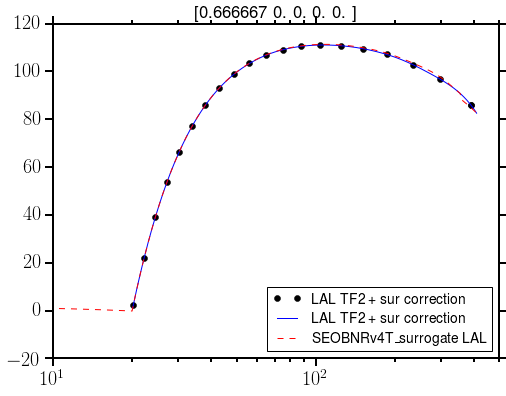

In [171]:
#plt.semilogx(fHz_gt_fLow, spline(TF2_phi_at_nodes.T[0], TF2_phi_at_nodes.T[1])(mfs) + 65.17, label='LAL TF2')

plt.semilogx(TF2_phi_at_nodes.T[0] / Mtot_sec, spline(TF2_phi_at_nodes.T[0], TF2_phi_at_nodes.T[1])(TF2_phi_at_nodes.T[0]) + 65.17
             + spline(sur_phi_at_nodes.T[0], sur_phi_at_nodes.T[1])(TF2_phi_at_nodes.T[0]), 'ko', label='LAL TF2 + sur correction')

plt.semilogx(fHz_gt_fLow, spline(TF2_phi_at_nodes.T[0], TF2_phi_at_nodes.T[1])(mfs) + 65.17
             + spline(sur_phi_at_nodes.T[0], sur_phi_at_nodes.T[1])(mfs), label='LAL TF2 + sur correction')

plt.semilogx(fHz, np.unwrap(np.angle(h)) - 0.11*fHz + 2, 'r--', label='SEOBNRv4T\_surrogate LAL')

plt.legend(loc=4)
plt.title(x)
plt.xlim([10, 500]);
plt.ylim([-20, 120]);

## Ongoing testing of C code

In [14]:
# x = np.array([1.0/1.5, 0.35, 0.32, 1.0, 1.0])
# x = np.array([1.0/1.5, 0.35, 0.32, 5000.0, 5000.0])

In [15]:
x = x_test_point
x

array([6.666667e-01, 3.500000e-01, 3.200000e-01, 1.000000e+03, 1.500000e+03])

Choose parameters consistent with the test case above where the x array is defined.

In [16]:
q = 1.0/x[0]
chi1 = x[1]
chi2 = x[2]
lambda1 = x[3]
lambda2 = x[4]

Mtot = 40.0

Calling `SimIMRSEOBNRv4TSurrogate` will print a bunch of debug output some of which I copy an paste in this notebook to compare.

In [17]:
phiRef, deltaF, fLow, fHigh, fRef, distance, inclination = 0, 0.1, 20, 0, 20, 1, 0
m1 = q/(1.0+q)*Mtot
m2 = 1.0/(1.0+q)*Mtot
m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max = m1*lal.MSUN_SI, m2*lal.MSUN_SI, chi1, chi2, lambda1, lambda2, -1

hp, hc = LS.SimIMRSEOBNRv4TSurrogate(phiRef, deltaF, fLow, fHigh, fRef, distance, inclination, 
                m1SI, m2SI, chi1, chi2, lambda1, lambda2, LS.SEOBNRv4TSurrogate_CUBIC)
h = hp.data.data + 1j*hc.data.data
fHz = np.arange(hp.data.length)*hp.deltaF

In [18]:
# For comparison generate a TaylorF2 waveform (including tides and self-spin)
LALpars = lal.CreateDict()

quad1 = f2.quad_of_lambda_fit(lambda1)
quad2 = f2.quad_of_lambda_fit(lambda2)
LS.SimInspiralWaveformParamsInsertdQuadMon1(LALpars, quad1 - 1)
LS.SimInspiralWaveformParamsInsertdQuadMon2(LALpars, quad2 - 1)
LS.SimInspiralWaveformParamsInsertTidalLambda1(LALpars, lambda1)
LS.SimInspiralWaveformParamsInsertTidalLambda2(LALpars, lambda2)


hpTF2 = LS.SimInspiralTaylorF2(phiRef, deltaF,
                                      m1SI, m2SI, 
                                      chi1, chi2,
                                      fLow, fHigh, fRef, distance, LALpars)
# Compute the two polarizations
cfac = cos(inclination)
pfac = 0.5 * (1.0 + cfac**2)

fHzTF2 = np.arange(hpTF2.data.length)*hpTF2.deltaF

hpTF2_data = pfac * hpTF2.data.data
hcTF2_data = -1j*cfac * hpTF2.data.data
hTF2 = hpTF2_data +1j*hcTF2_data

In [62]:
fHz_gt_fLow = fHz[np.where(fHz > fLow)]
h_sur = TEOB_surrogate_Python(Mtot, x, fHz_gt_fLow, sur_data_file)

In [63]:
Mtot_sec = Mtot * lal.MTSUN_SI
mfs = fHz_gt_fLow * Mtot_sec
# Compute TaylorF2 reference waveform
h_ref = geometric_reference_waveform(x, mfs, spin_spin=False)

**FIXME:** high frequency behavior?

Clearly the spline frequency grid would need to be denser if the surrogate was to be evaluated at such high total mass.
Check whether this problem also appears for sensible BNS total masses.

In [64]:
f_high = 0.07 / (Mtot * lal.MTSUN_SI)

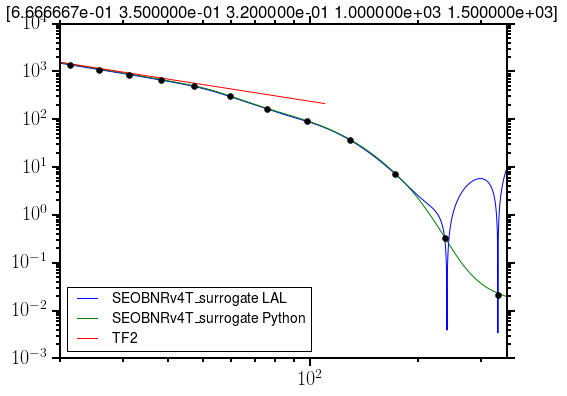

In [65]:
plt.loglog(fHz, np.abs(h), '-', label='SEOBNRv4T\_surrogate LAL')
plt.loglog(fHz_gt_fLow, 12*h_sur.amp, label='SEOBNRv4T\_surrogate Python')
plt.loglog(fHzTF2, np.abs(hTF2), label='TF2');
plt.loglog(TF2_Mf_amp_cubic / (Mtot*lal.MTSUN_SI), 
           spline(fHz, np.abs(h), k=3)(TF2_Mf_amp_cubic / (Mtot*lal.MTSUN_SI)), 'ko')

plt.legend(loc=3)
plt.title(x)
plt.xlim([20, f_high]);
plt.ylim([1e-3, 1e4]);

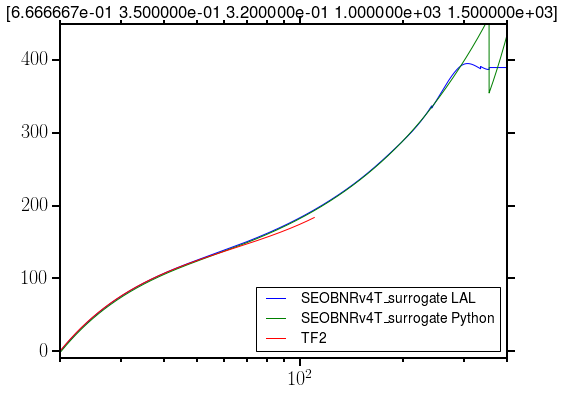

In [69]:
plt.semilogx(fHz, np.unwrap(np.angle(h)) - 0.*fHz - 0, label='SEOBNRv4T\_surrogate LAL')
plt.semilogx(fHz_gt_fLow, h_sur.phase - 0.42*fHz_gt_fLow - 0, label='SEOBNRv4T\_surrogate Python')
plt.semilogx(fHzTF2, np.unwrap(np.angle(hTF2)) + 0.2*fHzTF2 - 1, label='TF2');
plt.legend(loc=4)
plt.title(x)
plt.xlim([20, 400]);
plt.ylim([-10, 450]);

In [70]:
# TF2 phasing used in LAL code
TF2_phi_at_nodes = np.loadtxt('TF2_phi_at_nodes.dat')

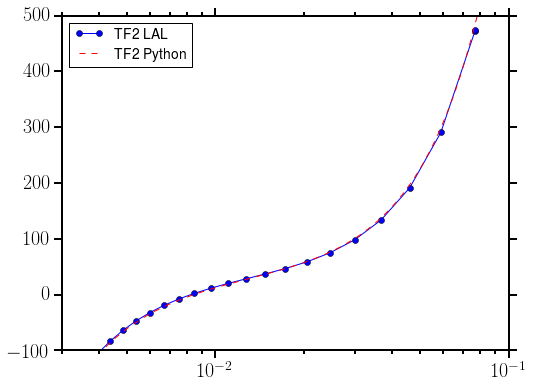

In [74]:
plt.semilogx(TF2_phi_at_nodes.T[0], TF2_phi_at_nodes.T[1], 'bo-', label='TF2 LAL')
plt.semilogx(mfs, h_ref.phase + 200*mfs - 110, 'r--', label='TF2 Python');
plt.xlim([3e-3, 1e-1]);
plt.ylim([-100, 500]);
plt.legend(loc=2);

There was an obvious deviation in the TF2 base waveform. The fix was: `pn_ss3 * pn->v[0]`.

The LAL code is using this:
```
pfa->v[6] base: -1071.08
pfa->v[6] spin term: 672.129
pfa->v[6] pn_ss3: 333.563
pn_ss3: 333.563
q: 1.5
chi1, chi2: 0.35, 0.32
lambda1, lambda2: 1000, 1500
quad1, quad2: 7.35093, 8.31964
v[0]: 0.0976563
v[1]: 0
v[2]: 0.623114
v[3]: -3.86435
v[4]: 1.93173
v[5]: 6.90498
v[6]: -38.9599
v[7]: -53.924
v[10]: -2324.25
v[12]: -5854.34
vlogv[5]: 20.7149
vlogv[6]: -31.8452
```

`f2.taylorf2_phase`

In [75]:
def taylorf2_phase(mf, tbymc, phic, eta, chi1, chi2, lambda1, lambda2, quad1=None, quad2=None, spin_spin=True):
    """3.5PN point-particle phase.
    FFT sign convention is $\tilde h(f) = \int h(t) e^{-2 \pi i f t} dt$
    where $h(t) = h_+(t) + i h_\times(t)$.
    """
    if quad1==None:
        quad1 = f2.quad_of_lambda_fit(lambda1)
    if quad2==None:
        quad2 = f2.quad_of_lambda_fit(lambda2)
    print 'quad1, quad2:', quad1, quad2

    print 'eta, chi1, chi2, lambda1, lambda2:', eta, chi1, chi2, lambda1, lambda2

    tlam = f2.lamtilde_of_eta_lam1_lam2(eta, lambda1, lambda2)
    dtlam = f2.deltalamtilde_of_eta_lam1_lam2(eta, lambda1, lambda2)

    # Calculate the coefficients once
    a00 = 3.0/(128.0*eta)

    a10 = 3715.0/756.0 + 55.0*eta/9.0

    a15 = -16.0*np.pi

    a20 = 15293365.0/508032.0 + (27145.0*eta)/504.0 + (3085.0*eta**2)/72.0

    a25 = (38645.0/756.0 - 65.0*eta/9)*np.pi

    a25ln = (3.0/2.0) * (38645.0/756.0 - (65.0*eta)/9.0)*np.pi

    a30 = 11583231236531.0/4694215680.0 - (6848.0*euler_gamma)/21.0 - (640.0*np.pi**2)/3.0 - 6848.0/63.0*np.log(64.0) \
    + (-15737765635.0/3048192.0 + (2255.0*np.pi**2)/12.0)*eta \
    + (76055.0*eta**2)/1728.0 \
    - (127825.0*eta**3)/1296.0

    a30ln = -(3.0/2.0) * 6848.0/63.0

    a35 = (77096675.0/254016.0 + (378515.0*eta)/1512.0 - (74045.0*eta**2)/756.0)*np.pi

    # The 3PN SS term that is not currently included in SEOBNRv4T
    pn_ss3 = f2.taylorf2_phase_30pn_spin(eta, chi1, chi2, quad1, quad2, spin_spin=True) - f2.taylorf2_phase_30pn_spin(eta, chi1, chi2, quad1, quad2, spin_spin=False)
    print 'base term:', a30
    print 'spin term:', f2.taylorf2_phase_30pn_spin(eta, chi1, chi2, quad1, quad2, spin_spin=False)
    print 'pn_ss3:', pn_ss3

    a15 += f2.taylorf2_phase_15pn_spin(eta, chi1, chi2)
    a20 += f2.taylorf2_phase_20pn_spin(eta, chi1, chi2, quad1, quad2)
    s25, s25ln = f2.taylorf2_phase_25pn_spin(eta, chi1, chi2)
    a25 += s25
    a25ln += s25ln
    # a30 += f2.taylorf2_phase_30pn_spin(eta, chi1, chi2, quad1, quad2)
    # a30 += f2.taylorf2_phase_30pn_spin(eta, chi1, chi2, 1.0, 1.0)
    a30 += f2.taylorf2_phase_30pn_spin(eta, chi1, chi2, quad1, quad2, spin_spin=spin_spin)
    a35 += f2.taylorf2_phase_35pn_spin(eta, chi1, chi2)

    a50 = -39.0*tlam/2.0
    a60 = -3115.0*tlam/64.0 + 6595.0*np.sqrt(1.0-4.0*eta)*dtlam/364.0

    print '\n***PN terms multiplied by Newtonian term:***\n'
    print 'a00, a10, a15, a20, a25, a30, a35:', a00, a00*a10, a00*a15, a00*a20, a00*a25, a00*a30, a00*a35, '\n'
    print 'a25ln, a30ln:', a00*a25ln, a00*a30ln, '\n'
    print '2*a25ln, 2*a30ln:', 2*a00*a25ln, 2*a00*a30ln, '\n'
    print 'a50, a60:', a00*a50, a00*a60, '\n'
    
    # Now calculate phase for each freq
    x = (np.pi*mf)**(2.0/3.0)


    phi = -2.0*np.pi*mf*tbymc + phic + np.pi/4.0
    phi -= a00*x**(-5.0/2.0)*(1.0 + a10*x + a15*x**1.5 + a20*x**2.0 \
                             + (a25 + a25ln*np.log(x))*x**2.5 \
                             + (a30 + a30ln*np.log(x))*x**3.0 \
                             + a35*x**3.5 \
                             + a50*x**5 + a60*x**6)
    return phi

In [76]:
q, s1, s2, lambda1, lambda2 = x
eta = q/(1.+q)**2
print x, '\n'
quad1, quad2 = None, None
spin_spin = False
phase_f2 = f2.taylorf2_phase(mfs, 0., 0., eta, s1, s2, 
                             lambda1, lambda2, quad1, quad2, 
                             spin_spin=spin_spin)
phase_f2_debug = taylorf2_phase(mfs, 0., 0., eta, s1, s2, 
                               lambda1, lambda2, quad1, quad2, 
                               spin_spin=spin_spin)
np.allclose(phase_f2_debug, phase_f2)

[6.666667e-01 3.500000e-01 3.200000e-01 1.000000e+03 1.500000e+03] 

quad1, quad2: 7.3509281821073635 8.31964296723627
eta, chi1, chi2, lambda1, lambda2: 0.24000000000000005 0.35 0.32 1000.0 1500.0
base term: -1071.0779874729228
spin term: 672.1290874698195
pn_ss3: 333.5626520481958

***PN terms multiplied by Newtonian term:***

a00, a10, a15, a20, a25, a30, a35: 0.09765624999999999 0.6231140459656084 -3.864350500400718 1.9317278092655283 6.904976203141382 -38.95985351592805 -53.92399568944781 

a25ln, a30ln: 10.357464304712071 -15.922619047619044 

2*a25ln, 2*a30ln: 20.714928609424142 -31.845238095238088 

a50, a60: -2324.2500000000005 -5854.339285714287 



True

```
pfa->v[6] base: -1071.08
pfa->v[6] spin term: 672.129
pfa->v[6] pn_ss3: 333.563
pn_ss3: 333.563
q: 1.5
chi1, chi2: 0.35, 0.32
lambda1, lambda2: 1000, 1500
quad1, quad2: 7.35093, 8.31964
v[0]: 0.0976563
v[1]: 0
v[2]: 0.623114
v[3]: -3.86435
v[4]: 1.93173
v[5]: 6.90498
v[6]: -38.9599
v[7]: -53.924
v[10]: -2324.25
v[12]: -5854.34
vlogv[5]: 20.7149
vlogv[6]: -31.8452
```

In [28]:
# Subtract off the 3PM SS term in v6
(-1071.08 + 672.129 + 333.563) * 0.0976563 - 333.563 * 0.0976563

-38.96007854129999

In [29]:
LALpars = lal.CreateDict()
LS.SimInspiralWaveformParamsInsertPNSpinOrder(LALpars, LS.SIM_INSPIRAL_SPIN_ORDER_35PN);

quad1 = f2.quad_of_lambda_fit(lambda1)
quad2 = f2.quad_of_lambda_fit(lambda2)
LS.SimInspiralWaveformParamsInsertdQuadMon1(LALpars, quad1 - 1)
LS.SimInspiralWaveformParamsInsertdQuadMon2(LALpars, quad2 - 1)
LS.SimInspiralWaveformParamsInsertTidalLambda1(LALpars, lambda1)
LS.SimInspiralWaveformParamsInsertTidalLambda2(LALpars, lambda2)

pn = LS.SimInspiralTaylorF2AlignedPhasing(m1SI, m2SI, chi1, chi2, LALpars)

The returned structure contains the PN coefficients, except for the tidal terms which we add later.

v[4], v[6] contain contributions from self-spin (quad1, quad2).

In [30]:
pn.v

array([ 9.765625e-02,  0.000000e+00,  6.231140e-01, -3.864351e+00,  1.931728e+00,  6.904976e+00,
       -6.385376e+00, -5.392400e+01,  0.000000e+00,  0.000000e+00, -2.324250e+03,  0.000000e+00,
       -5.854339e+03])

In [31]:
# Subtract off the 3PM SS term in v6
pn.v[6] - 333.563 * 0.0976563

-38.9599041737464

In [32]:
pn.vlogv

array([  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,  20.714929, -31.845238,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ])

In [33]:
pn.vlogvsq

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [90]:
# tidal terms
pn.v[10], pn.v[12]

(-2324.2499999999995, -5854.339285714286)

The TF2 phase agrees very well now.

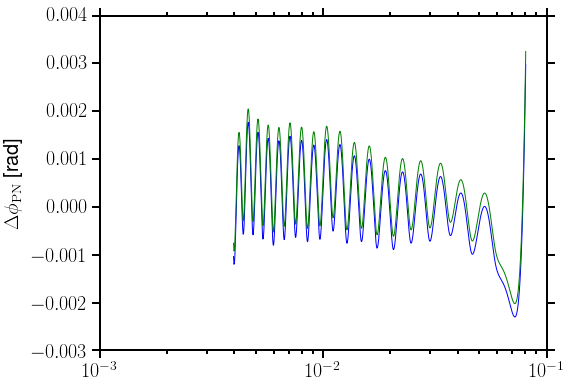

In [91]:
plt.semilogx(mfs, spline(TF2_phi_at_nodes.T[0], TF2_phi_at_nodes.T[1])(mfs) - h_ref.phase - 0*mfs + 106.365)
plt.semilogx(mfs, spline(TF2_phi_at_nodes.T[0], TF2_phi_at_nodes.T[1])(mfs) - phase_f2 + 0.785)

plt.ylabel(r'$\Delta\phi_\mathrm{PN}$ [rad]');

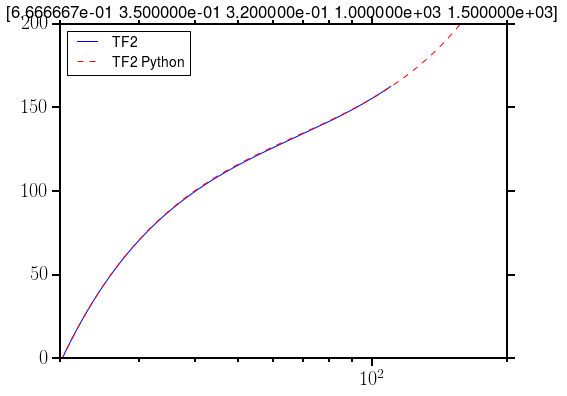

In [105]:
plt.semilogx(fHzTF2, np.unwrap(np.angle(hTF2)), label='TF2');
plt.semilogx(fHz_gt_fLow, h_ref.phase - 0.065*fHz_gt_fLow + 0, 'r--', label='TF2 Python');

plt.legend(loc=2)
plt.title(x)
plt.xlim([20, 200]);
plt.ylim([0, 200]);

So, it looks like the difference at high frequency comes from the correction or how it is being applied / interpolated.

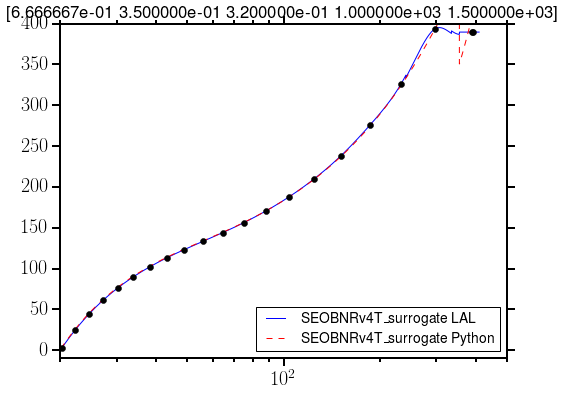

In [130]:
plt.semilogx(fHz, np.unwrap(np.angle(h)), label='SEOBNRv4T\_surrogate LAL')
plt.semilogx(fHz_gt_fLow, h_sur.phase - 0.44*fHz_gt_fLow + 3, 'r--', label='SEOBNRv4T\_surrogate Python')
# plt.semilogx(fHzTF2, np.unwrap(np.angle(hTF2)) + 1, label='TF2');
# plt.semilogx(fHz_gt_fLow, h_ref.phase, 'g--', label='TF2 Python');

plt.semilogx(TF2_Mf_phi_cubic / (Mtot*lal.MTSUN_SI), 
           spline(fHz, np.unwrap(np.angle(h)), k=3)(TF2_Mf_phi_cubic / (Mtot*lal.MTSUN_SI)), 'ko')

plt.legend(loc=4)
plt.title(x)
plt.xlim([20, 500]);
plt.ylim([-10, 400]);

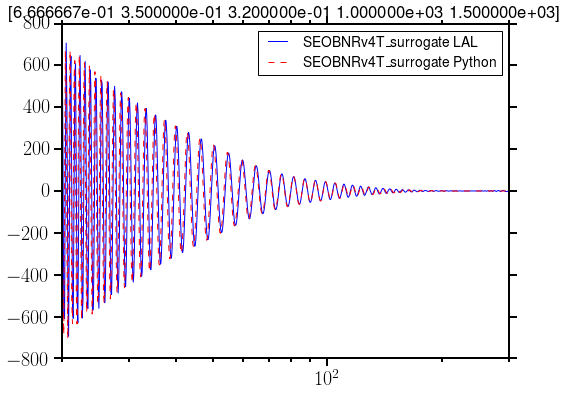

In [132]:
plt.semilogx(fHz, hp.data.data, label='SEOBNRv4T\_surrogate LAL');
plt.semilogx(fHz_gt_fLow, 5.8*h_sur.complex() * np.exp(1j*(- 0.44*fHz_gt_fLow + 3)), 'r--', label='SEOBNRv4T\_surrogate Python');
plt.legend(loc=1)
plt.title(x)
plt.xlim([20, 300]);

### Check PN phasing

In [34]:
# Copied from Terminal output
PN_phase_LAL = np.array([
19970.8623740172,
12015.6330086051,
7222.39483857474,
4333.99515435419,
2593.5166533687,
1545.04740751171,
913.851414121915,
534.276218281053,
306.364065763709,
169.722435590746,
87.7695257429162,
38.2079029306288,
7.21935977243947,
-14.1512904875418,
-32.3912245472999,
-53.3634320935435,
-84.1717930456965,
-135.7213025241,
-227.024821778381,
-393.163375831142])

In [35]:
h_ref_at_nodes = geometric_reference_waveform(x, mf_phi)

In [36]:
PN_phase_Python = h_ref_at_nodes.phase

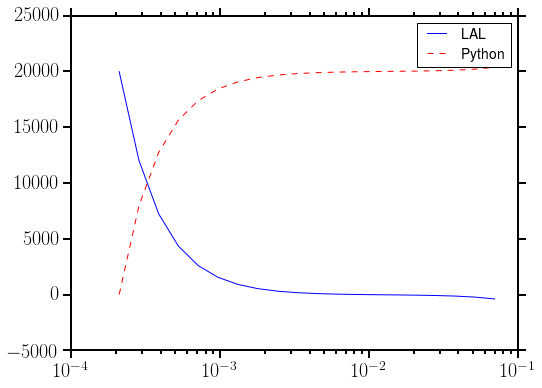

In [37]:
plt.semilogx(mf_phi, PN_phase_LAL, label='LAL')
plt.semilogx(mf_phi, PN_phase_Python, 'r--', label='Python')
plt.legend();

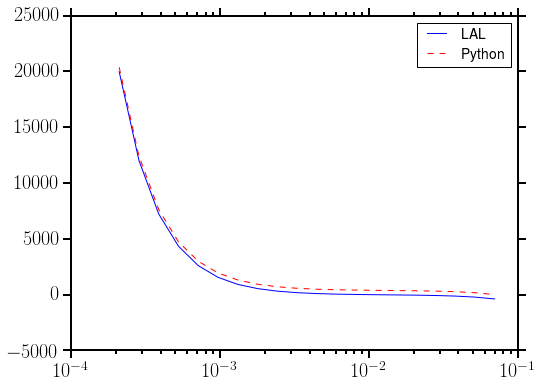

In [38]:
plt.semilogx(mf_phi, PN_phase_LAL, label='LAL')
plt.semilogx(mf_phi, -PN_phase_Python + max(PN_phase_Python), 'r--', label='Python')
plt.legend();

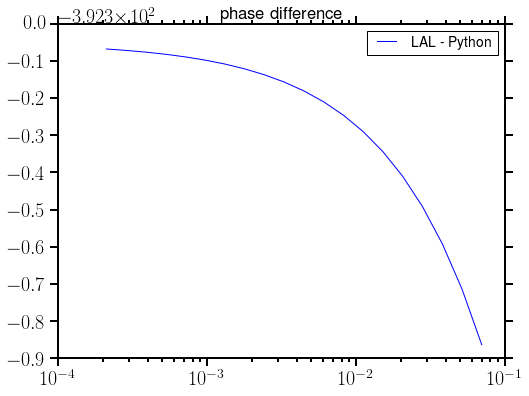

In [39]:
plt.semilogx(mf_phi, PN_phase_LAL - (-PN_phase_Python + max(PN_phase_Python)), label='LAL - Python')
plt.legend();
plt.title('phase difference');

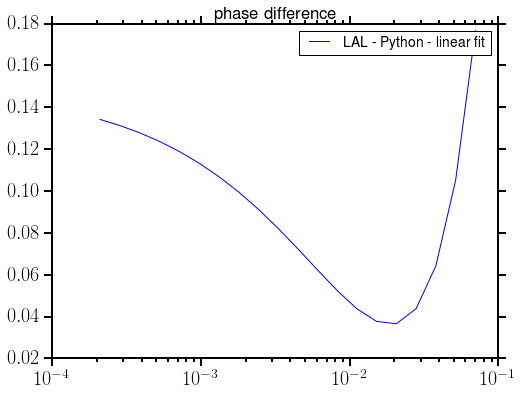

In [40]:
plt.semilogx(mf_phi, PN_phase_LAL - (-PN_phase_Python + max(PN_phase_Python)) + 392.5 + mf_phi*12, label='LAL - Python - linear fit')
plt.legend();
plt.title('phase difference');

Flipped sign of TF2 phase in LAL to, so there is agreement between the Python and LAL surrogate codes and the surrogate phase correction is applied in the correct direction.

## Obtain TF2 phase via SWIG-LAL and compare to LAL-C

As you can see at the end of this section, the agreement is very good.

In [43]:
q = 1.0/x[0]
chi1 = x[1]
chi2 = x[2]
lambda1 = x[3]
lambda2 = x[4]

Mtot = 40.0

In [44]:
extraParams = lal.CreateDict()
LS.SimInspiralWaveformParamsInsertPNSpinOrder(extraParams, LS.SIM_INSPIRAL_SPIN_ORDER_35PN);

m1OverM = q / (1.0+q);
m2OverM = 1.0 / (1.0+q);
m1 = Mtot * m1OverM
m2 = Mtot * m2OverM

pn = LS.SimInspiralTaylorF2AlignedPhasing(m1 * lal.MSUN_SI, m2 * lal.MSUN_SI, chi1, chi2, extraParams)

The returned structure contains the PN coefficients, except for the tidal terms which we add later.

In [45]:
pn.v

array([  0.097656,   0.      ,   0.623114,  -3.864351,   3.884858,   6.904976, -37.170777, -53.923996,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ])

In [46]:
pn.vlogv

array([  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,  20.714929, -31.845238,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ])

In [47]:
pn.vlogvsq

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [48]:
# Add tidal deformability terms

# Note: these functions are not callable outside this source file, even though they are XLAL
# Therefore I reimplement them here.
# See LALSimInspiralPNCoefficients.c

def XLALSimInspiralTaylorF2Phasing_10PNTidalCoeff(mByM):
    return (-288. + 264.*mByM)*mByM*mByM*mByM*mByM;

def XLALSimInspiralTaylorF2Phasing_12PNTidalCoeff(mByM):
    return (-15895./28. + 4595./28.*mByM + 5715./14.*mByM*mByM - 325./7.*mByM*mByM*mByM)*mByM*mByM*mByM*mByM;

print "Before adding tidal terms", pn.v[10], pn.v[12]

pn.v[10] = pn.v[0] * ( lambda1 * XLALSimInspiralTaylorF2Phasing_10PNTidalCoeff(m1OverM)
                     + lambda2 * XLALSimInspiralTaylorF2Phasing_10PNTidalCoeff(m2OverM) );
pn.v[12] = pn.v[0] * ( lambda1 * XLALSimInspiralTaylorF2Phasing_12PNTidalCoeff(m1OverM)
                     + lambda2 * XLALSimInspiralTaylorF2Phasing_12PNTidalCoeff(m2OverM) );

print "After adding tidal terms", pn.v[10], pn.v[12]

Before adding tidal terms 0.0 0.0
After adding tidal terms -2324.25 -5854.33928571


In [49]:
PN_phase_LAL_Python = []
for Mf in mf_phi:
    v = (lal.PI * Mf)**(1.0/3.0)
    logv = log(v)

    v2 = v * v;
    v3 = v * v2;
    v4 = v * v3;
    v5 = v * v4;
    v6 = v * v5;
    v7 = v * v6;
    v8 = v * v7;
    v9 = v * v8;
    v10 = v * v9;
    v12 = v2 * v10;
    phasing = 0.0;

    phasing += pn.v[7] * v7;
    phasing += (pn.v[6] + pn.vlogv[6] * logv) * v6;
    phasing += (pn.v[5] + pn.vlogv[5] * logv) * v5;
    phasing += pn.v[4] * v4;
    phasing += pn.v[3] * v3;
    phasing += pn.v[2] * v2;
    phasing += pn.v[1] * v;
    phasing += pn.v[0];

    # Tidal terms in phasing
    phasing += pn.v[12] * v12;
    phasing += pn.v[10] * v10;

    phasing /= v5;
    PN_phase_LAL_Python.append(phasing)
    #print phasing, pn.v[12] * v12, pn.v[10] * v10
    print Mf, v, phasing

PN_phase_LAL_Python = np.array(PN_phase_LAL_Python)

0.00021 0.0870541987232 19970.862374
0.000285103393483 0.0963941666465 12015.6330086
0.000387066404645 0.106736211461 7222.39483857
0.000525494978417 0.118187845109 4333.99515435
0.000713430483832 0.130868114395 2593.51665337
0.000968578342641 0.144908838548 1545.04740751
0.00131497605877 0.160455979567 913.851414122
0.00178525779382 0.177671159584 534.276218281
0.00242372883458 0.196733341027 306.364065764
0.00329053959819 0.217840687043 169.722435591
0.00446735240873 0.24121262153 87.7695257429
0.00606503491244 0.267092110181 38.2079029306
0.00823410492919 0.29574818626 7.21935977244
0.0111789107505 0.327478747377 -14.1512904875
0.0151768828115 0.36261365231 -32.3912245473
0.0206046704383 0.401518150092 -53.3634320935
0.0279736260169 0.444596677004 -84.1717930457
0.0379779795497 0.492297060936 -135.721302524
0.0515602421298 0.545115176838 -227.024821778
0.07 0.603600101643 -393.163375831


In [50]:
np.allclose(PN_phase_LAL, PN_phase_LAL_Python)

True

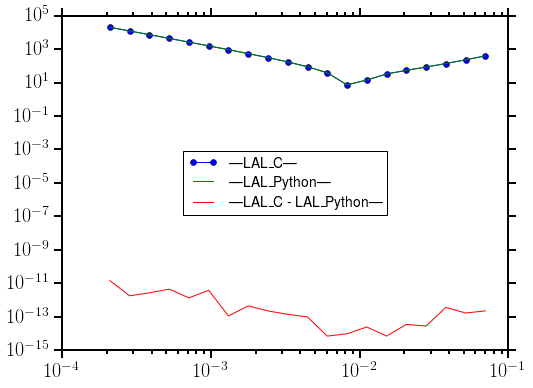

In [57]:
plt.loglog(mf_phi, np.abs(PN_phase_LAL), 'o-', label=r'|LAL\_C|')
plt.loglog(mf_phi, np.abs(PN_phase_LAL_Python), label=r'|LAL\_Python|')
plt.loglog(mf_phi, np.abs(PN_phase_LAL - PN_phase_LAL_Python), '-', label=r'|LAL\_C - LAL\_Python|')
plt.legend(loc=10);

## 1PN amplitude

In [33]:
def taylorf2_amp_1pn(mf, eta):
    """1PN point-particle amplitude. where h(f) = h_+(f) + i h_x(f).
    Expression from Eq. (6.10) of arXiv:0810.5336.
    !!! This is technically wrong since you have a x**2 term (need to re-expand). !!!
    Parameters
    ----------
    mf : numpy array or float
        Geometric frequency. Most efficient when mf is a numpy array.
    Returns
    -------
    amp : numpy array or float
        Amplitude of h(f) = h_+(f) + i h_x(f) in geometric units.
    """
    x = (np.pi*mf)**(2.0/3.0)
    a00 = np.sqrt( (5.0*np.pi/24.0)*eta )
    a10 = -323./224. + 451.*eta/168.
    return 2.0*a00 * x**(-7./4.) * (1. + a10*x)

In [35]:
def etafun(q):
    return q / (1.0+q)**2

In [41]:
AmpPN_at_nodes_Python = taylorf2_amp_1pn(mf_phi, etafun(q))

In [40]:
AmpPN_at_nodes_LAL_C = np.array([
4047.5531555559,
2829.31539991122,
1977.12411513888,
1381.0801975125,
964.267436079086,
672.85545231024,
469.17216669043,
326.854846797055,
227.456096268303,
158.068251790255,
109.660626591625,
75.9157159577056,
52.4146520685744,
36.0671141726683,
24.7123420619561,
16.8399093393479,
11.3943183049892,
7.63826154705543,
5.05694324100059,
3.29113642458537])

In [42]:
np.allclose(AmpPN_at_nodes_Python, AmpPN_at_nodes_LAL_C)

True

In [43]:
AmpPN_at_nodes_Python - AmpPN_at_nodes_LAL_C

array([ -4.547474e-13,  -3.183231e-12,  -1.591616e-12,   0.000000e+00,   4.547474e-13,  -3.410605e-13,
        -2.842171e-13,  -4.547474e-13,   4.547474e-13,   3.979039e-13,  -2.842171e-14,   1.421085e-14,
         4.263256e-14,   4.973799e-14,  -3.907985e-14,   2.842171e-14,   2.309264e-14,  -6.217249e-15,
         0.000000e+00,   1.776357e-15])

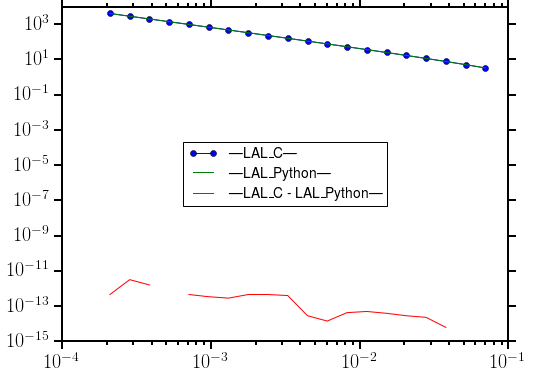

In [45]:
plt.loglog(mf_phi, np.abs(AmpPN_at_nodes_LAL_C), 'o-', label=r'|LAL\_C|')
plt.loglog(mf_phi, np.abs(AmpPN_at_nodes_Python), label=r'|LAL\_Python|')
plt.loglog(mf_phi, np.abs(AmpPN_at_nodes_LAL_C - AmpPN_at_nodes_Python), '-', label=r'|LAL\_C - LAL\_Python|')
plt.legend(loc=10);

## Test cases for regression test

MP: Updated to agree with major C code cleaning Nov 17, 2017.

In [182]:
x = np.array([1.0/1.5, 0.35, 0.32, 1.0, 1.0])
x = np.array([1.0/1.5, 0.35, 0.32, 5000.0, 5000.0])

In [183]:
q = 1.0/x[0]
chi1 = x[1]
chi2 = x[2]
lambda1 = x[3]
lambda2 = x[4]

Mtot = 40.0

In [184]:
# SEOBNRv4ROM
phiRef, deltaF, fLow, fHigh, fRef, distance, inclination = 0, 0.1, 20, 0, 20, 1, 0
m1 = q/(1.0+q)*Mtot
m2 = 1.0/(1.0+q)*Mtot
m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max = m1*lal.MSUN_SI, m2*lal.MSUN_SI, chi1, chi2, lambda1, lambda2, -1

hpSEOBNRv4, hcSEOBNRv4 = LS.SimIMRSEOBNRv4ROM(phiRef, deltaF, fLow, fHigh, fRef, distance, inclination, 
                m1SI, m2SI, chi1, chi2, nk_max)

fHz_SEOBNRv4 = np.arange(hpSEOBNRv4.data.length)*hpSEOBNRv4.deltaF
h_SEOBNRv4 = hpSEOBNRv4.data.data + 1j*hcSEOBNRv4.data.data

In [185]:
# TEOBv4ROM
phiRef, deltaF, fLow, fHigh, fRef, distance, inclination = 0, 0.1, 20, 0, 20, 1, 0
m1 = q/(1.0+q)*Mtot
m2 = 1.0/(1.0+q)*Mtot
m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max = m1*lal.MSUN_SI, m2*lal.MSUN_SI, chi1, chi2, lambda1, lambda2, -1

hpTEOBv4, hcTEOBv4 = LS.SimIMRTEOBv4ROM(phiRef, deltaF, fLow, fHigh, fRef, distance, inclination, 
                m1SI, m2SI, chi1, chi2, lambda1, lambda2)

fHz_TEOBv4 = np.arange(hpTEOBv4.data.length)*hpTEOBv4.deltaF
h_TEOBv4 = hpTEOBv4.data.data + 1j*hcTEOBv4.data.data

In [186]:
# TaylorF2
LALpars = lal.CreateDict()
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1(LALpars, lambda1)
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda2(LALpars, lambda2)

hpTF2 = LS.SimInspiralTaylorF2(phiRef, deltaF,
                                      m1SI, m2SI, 
                                      chi1, chi2,
                                      fLow, fHigh, fRef, distance, LALpars)
# Compute the two polarizations
cfac = cos(inclination)
pfac = 0.5 * (1.0 + cfac**2)

hpTF2_data = pfac * hpTF2.data.data
hcTF2_data = -1j*cfac * hpTF2.data.data
h_TF2 = hpTF2_data +1j*hcTF2_data
fHz_TF2 = np.arange(hpTF2.data.length)*hpTF2.deltaF

In [187]:
# TEOBv4 FFT via SimInspiralFD
longAscNodes, eccentricity, meanPerAno = 0,0,0

LALpars = lal.CreateDict()
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1(LALpars, lambda1)
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda2(LALpars, lambda2)

# Nyquist frequency is set by fHigh
# Can set deltaF = 0 to figure out required frequency spacing
hpTEOBv4FD, hcTEOBv4FD = LS.SimInspiralFD(m1SI, m2SI,
                 0.0, 0.0, chi1,
                 0.0, 0.0, chi2,
                 distance, inclination, phiRef, 
                 longAscNodes, eccentricity, meanPerAno, 
                 0.0,
                 fLow, 16384, fRef,
                 LALpars,
                 LS.TEOBv4)

fHz_TEOBv4FD = np.arange(hpTEOBv4FD.data.length)*hpTEOBv4FD.deltaF
h_TEOBv4FD = hpTEOBv4FD.data.data + 1j*hcTEOBv4FD.data.data

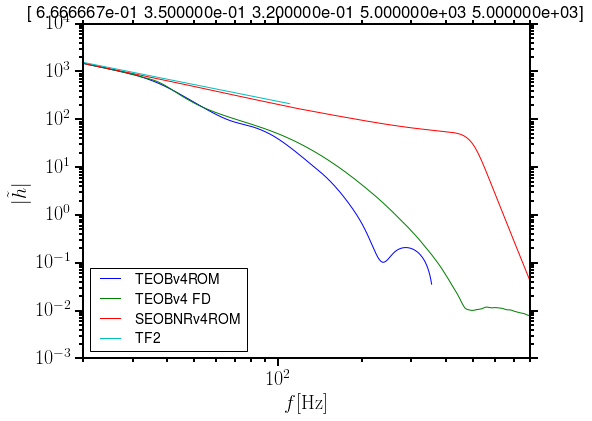

In [141]:
plt.loglog(fHz_TEOBv4, np.abs(h_TEOBv4), label='TEOBv4ROM')
plt.loglog(fHz_TEOBv4FD, np.abs(h_TEOBv4FD), label='TEOBv4 FD')
plt.loglog(fHz_SEOBNRv4, np.abs(h_SEOBNRv4), label='SEOBNRv4ROM')
plt.loglog(fHz_TF2, np.abs(h_TF2), label='TF2');
plt.legend(loc=3)
plt.title(x)
plt.xlabel(r'$f[\mathrm{Hz}]$')
plt.ylabel(r'$|\tilde h|$')
plt.xlim([20, 800]);
plt.ylim([1e-3, 1e4]);

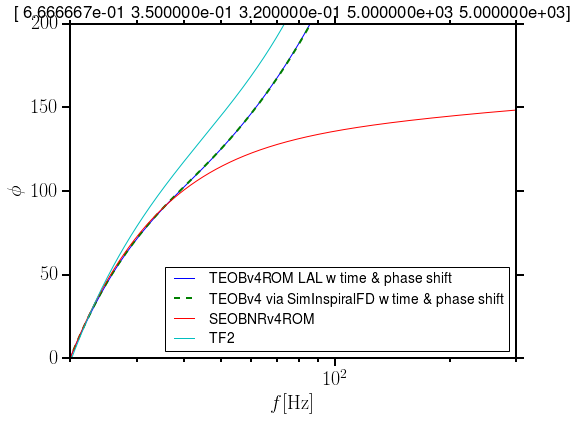

In [165]:
plt.semilogx(fHz_TEOBv4, np.unwrap(np.angle(h_TEOBv4)) + 2.1*fHz_TEOBv4 - 42, label='TEOBv4ROM LAL w time \& phase shift')
plt.semilogx(fHz_TEOBv4FD, np.unwrap(np.angle(h_TEOBv4FD)) + 1.9*fHz_TEOBv4FD + 25, 'g--', lw=2, label='TEOBv4 via SimInspiralFD  w time \& phase shift')
plt.semilogx(fHz_SEOBNRv4, np.unwrap(np.angle(h_SEOBNRv4)), 'r-', label='SEOBNRv4ROM')
plt.semilogx(fHz_TF2, np.unwrap(np.angle(h_TF2)), 'c-', label='TF2');
plt.legend(loc=4)
plt.title(x)
plt.xlabel(r'$f[\mathrm{Hz}]$')
plt.ylabel(r'$\phi$')
plt.xlim([20, 300]);
plt.ylim([0, 200]);

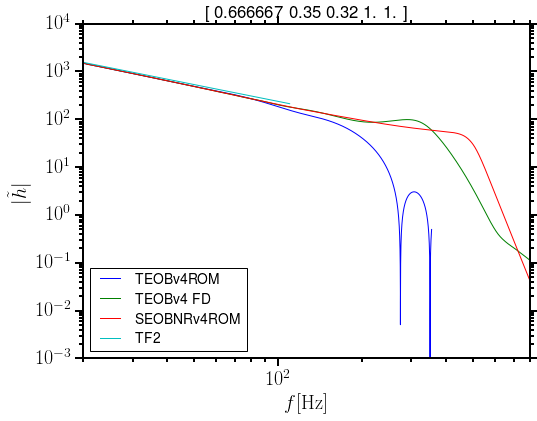

In [172]:
# There is some artefact : TEOBv4ROM should use a parameter dependent BNS merger cutoff frequency
# FIXME: Somehow this is not quite enough!
# The amplitude is very different between the surrogate and the FFT of the TD model - do they agree well in the TD for these parameters?
plt.loglog(fHz_TEOBv4, np.abs(h_TEOBv4), label='TEOBv4ROM')
plt.loglog(fHz_TEOBv4FD, np.abs(h_TEOBv4FD), label='TEOBv4 FD')
plt.loglog(fHz_SEOBNRv4, np.abs(h_SEOBNRv4), label='SEOBNRv4ROM')
plt.loglog(fHz_TF2, np.abs(h_TF2), label='TF2');
plt.legend(loc=3)
plt.title(x)
plt.xlabel(r'$f[\mathrm{Hz}]$')
plt.ylabel(r'$|\tilde h|$')
plt.xlim([20, 800]);
plt.ylim([1e-3, 1e4]);

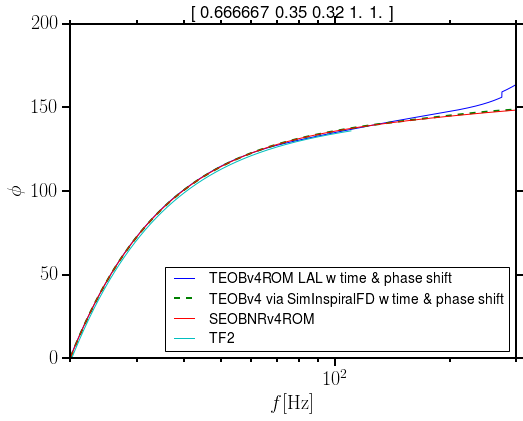

In [181]:
plt.semilogx(fHz_TEOBv4, np.unwrap(np.angle(h_TEOBv4)) + 0.22*fHz_TEOBv4 - 4, label='TEOBv4ROM LAL w time \& phase shift')
plt.semilogx(fHz_TEOBv4FD, np.unwrap(np.angle(h_TEOBv4FD)) - 0.125*fHz_TEOBv4FD + 131, 'g--', lw=2, label='TEOBv4 via SimInspiralFD  w time \& phase shift')
plt.semilogx(fHz_SEOBNRv4, np.unwrap(np.angle(h_SEOBNRv4)), 'r-', label='SEOBNRv4ROM')
plt.semilogx(fHz_TF2, np.unwrap(np.angle(h_TF2)), 'c-', label='TF2');
plt.legend(loc=4)
plt.title(x)
plt.xlabel(r'$f[\mathrm{Hz}]$')
plt.ylabel(r'$\phi$')
plt.xlim([20, 300]);
plt.ylim([0, 200]);

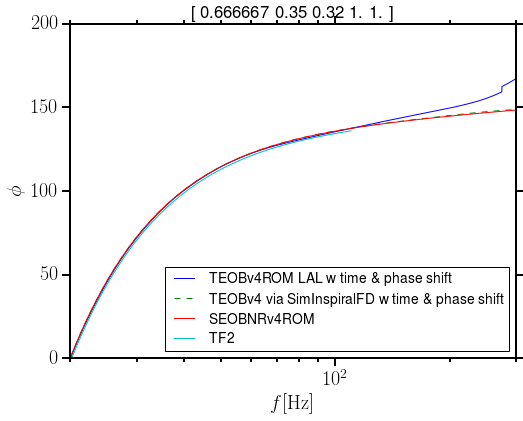

In [118]:
plt.semilogx(fHz_TEOBv4, np.unwrap(np.angle(h_TEOBv4)) + 0.28*fHz_TEOBv4 - 6, label='TEOBv4ROM LAL w time \& phase shift')
plt.semilogx(fHz_TEOBv4FD, np.unwrap(np.angle(h_TEOBv4FD)) - 0.125*fHz_TEOBv4FD + 131, 'g--', label='TEOBv4 via SimInspiralFD  w time \& phase shift')
plt.semilogx(fHz_SEOBNRv4, np.unwrap(np.angle(h_SEOBNRv4)), 'r-', label='SEOBNRv4ROM')
plt.semilogx(fHz_TF2, np.unwrap(np.angle(h_TF2)), 'c-', label='TF2');
plt.legend(loc=4)
plt.title(x)
plt.xlabel(r'$f[\mathrm{Hz}]$')
plt.ylabel(r'$\phi$')
plt.xlim([20, 300]);
plt.ylim([0, 200]);

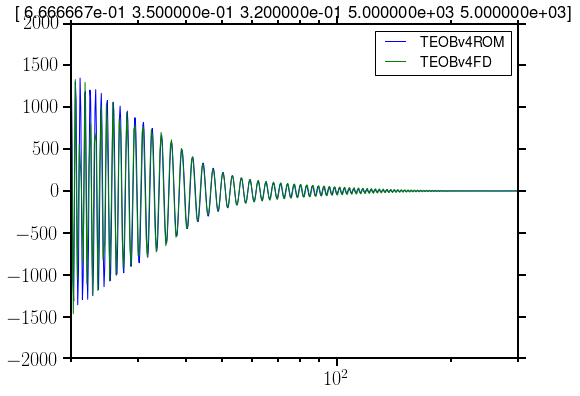

In [188]:
plt.semilogx(fHz_TEOBv4, np.real(h_TEOBv4 * np.exp(1j*(+2.1*fHz_TEOBv4 - 42))), label='TEOBv4ROM');
plt.semilogx(fHz_TEOBv4FD, np.real(h_TEOBv4FD * np.exp(1j*(+1.9*fHz_TEOBv4FD + 25))), label='TEOBv4FD');
#plt.semilogx(fHz_SEOBNRv4, np.real(h_SEOBNRv4), label='SEOBNRv4ROM');
#plt.semilogx(fHz_TF2, h_TF2.real, label='TF2');
plt.legend()
plt.title(x)
plt.xlim([20, 300]);

## Regression test for LAL C code for TEOBv4ROM

In [12]:
x = np.array([1.0/1.5, 0.35, 0.32, 5000.0, 5000.0])

In [13]:
q = 1.0/x[0]
chi1 = x[1]
chi2 = x[2]
lambda1 = x[3]
lambda2 = x[4]

Mtot = 40.0

In [14]:
DR = '/Users/mpuer/Documents/gpsurrogate/src/TEOB-LAL-implementation/regression-data/'
file_name = DR+'TEOBv4ROM_reg_data_%g_%g_%g_%g_%g.npy'%(q,chi1,chi2,lambda1,lambda2)

### Save TEOBv4ROM regression data

Cell was converted into Markdown to avoid overwriting the regression data

```Python
# TEOBv4ROM
phiRef, deltaF, fLow, fHigh, fRef, distance, inclination = 0, 0.1, 20, 0, 20, 1, 0
m1 = q/(1.0+q)*Mtot
m2 = 1.0/(1.0+q)*Mtot
m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max = m1*lal.MSUN_SI, m2*lal.MSUN_SI, chi1, chi2, lambda1, lambda2, -1

hpTEOBv4, hcTEOBv4 = LS.SimIMRTEOBv4ROM(phiRef, deltaF, fLow, fHigh, fRef, distance, inclination, 
                m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max)

fHz_TEOBv4 = np.arange(hpTEOBv4.data.length)*hpTEOBv4.deltaF
h_TEOBv4 = hpTEOBv4.data.data + 1j*hcTEOBv4.data.data

np.save(file_name, np.vstack([fHz_TEOBv4, h_TEOBv4]))
```

### Load regression data and compare against new TEOBv4ROM waveform

In [30]:
# TEOBv4ROM
phiRef, deltaF, fLow, fHigh, fRef, distance, inclination = 0, 0.1, 20, 0, 20, 1, 0
m1 = q/(1.0+q)*Mtot
m2 = 1.0/(1.0+q)*Mtot
m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max = m1*lal.MSUN_SI, m2*lal.MSUN_SI, chi1, chi2, lambda1, lambda2, -1

hpTEOBv4, hcTEOBv4 = LS.SimIMRTEOBv4ROM(phiRef, deltaF, fLow, fHigh, fRef, distance, inclination, 
                m1SI, m2SI, chi1, chi2, lambda1, lambda2)

fHz_TEOBv4 = np.arange(hpTEOBv4.data.length)*hpTEOBv4.deltaF
h_TEOBv4 = hpTEOBv4.data.data + 1j*hcTEOBv4.data.data

In [39]:
fHz_TEOBv4_reg, h_TEOBv4_reg = np.load(file_name)
fHz_TEOBv4_reg = np.abs(fHz_TEOBv4_reg)

In [41]:
# pull out common indices -- only zeros have changed
idx = np.abs(h_TEOBv4).nonzero()
idx_reg = np.abs(h_TEOBv4_reg).nonzero()

In [42]:
np.allclose(fHz_TEOBv4[idx], fHz_TEOBv4_reg[idx_reg])

True

In [43]:
# The timeshift in the phase has changed
np.allclose(h_TEOBv4[idx], h_TEOBv4_reg[idx_reg])

False

In [44]:
# Amplitudes are fine
np.allclose(np.abs(h_TEOBv4[idx]), np.abs(h_TEOBv4_reg[idx_reg]))

True

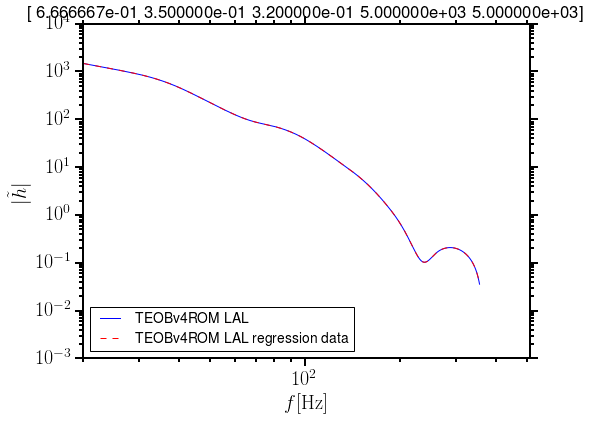

In [34]:
plt.loglog(fHz_TEOBv4, np.abs(h_TEOBv4), label='TEOBv4ROM LAL')
plt.loglog(fHz_TEOBv4_reg, np.abs(h_TEOBv4_reg), 'r--', label='TEOBv4ROM LAL regression data')
plt.legend(loc=3)
plt.title(x)
plt.xlabel(r'$f[\mathrm{Hz}]$')
plt.ylabel(r'$|\tilde h|$')
plt.xlim([20, 512]);
plt.ylim([1e-3, 1e4]);

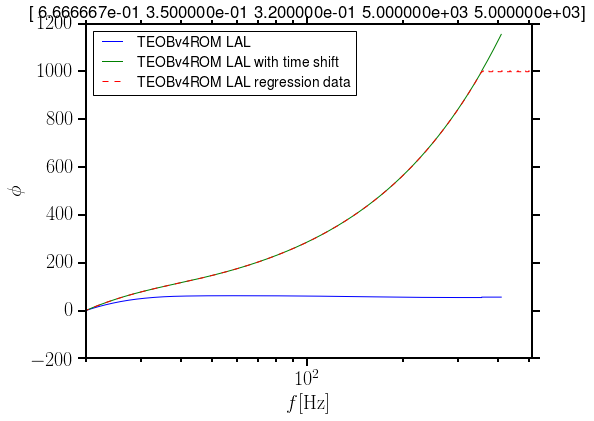

In [62]:
plt.semilogx(fHz_TEOBv4, np.unwrap(np.angle(h_TEOBv4)), label='TEOBv4ROM LAL')
plt.semilogx(fHz_TEOBv4, np.unwrap(np.angle(h_TEOBv4)) + 2.82*fHz_TEOBv4 - 56.4, label='TEOBv4ROM LAL with time shift')
plt.semilogx(fHz_TEOBv4_reg, np.unwrap(np.angle(h_TEOBv4_reg)), 'r--', label='TEOBv4ROM LAL regression data')
plt.legend(loc=2)
plt.title(x)
plt.xlabel(r'$f[\mathrm{Hz}]$')
plt.ylabel(r'$\phi$')
plt.xlim([20, 512]);

Correct for the timeshift to high accuracy

In [132]:
phi_TEOBv4_tcorr = np.unwrap(np.angle(h_TEOBv4[idx])) + 2.818753200485*fHz_TEOBv4[idx] - 56.375064009
phi_TEOBv4_reg = np.unwrap(np.angle(h_TEOBv4_reg))[idx_reg]

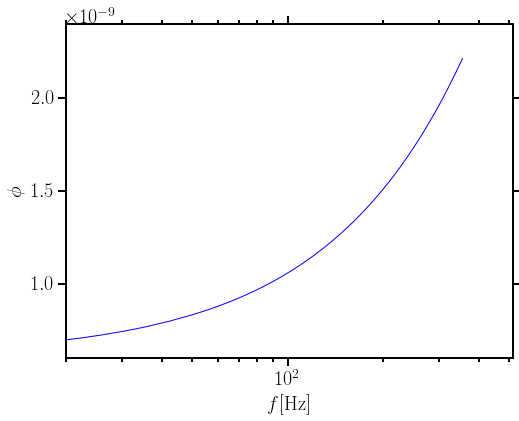

In [133]:
plt.semilogx(fHz_TEOBv4[idx], phi_TEOBv4_tcorr - phi_TEOBv4_reg)
#plt.title(x)
plt.xlabel(r'$f[\mathrm{Hz}]$')
plt.ylabel(r'$\phi$')
plt.xlim([20, 512]);

In [134]:
np.allclose(phi_TEOBv4_tcorr, phi_TEOBv4_reg)

True

We are good here.

## Fit to BNS merger frequency

$\kappa_2^T$ quadrupolar tidal coupling constant

Code in `LALSimIMRSpinAlignedEOB.c`

```C
/**
 * NR fit to the geometric GW frequency M_{total}omega_{22} of a BNS merger,
 * defined by the time when the (2,2) amplitude peaks
 * See Eq.(2) in https://arxiv.org/pdf/1504.01764.pdf with coefficients
 * given by the 3rd row of Table II therein. Compared to NR for 0 <= kappa2T <= 500
 */
static UNUSED REAL8 XLALSimNSNSMergerFreq(
                                       TidalEOBParams *tidal1, /**< Tidal parameters of body 1 */
                                       TidalEOBParams *tidal2  /**< Tidal parameters of body 2 */
)
{
    REAL8 X1 = tidal1->mByM;
    REAL8 X2 = tidal2->mByM;
    REAL8 lambda1 = tidal1->lambda2Tidal; // Dimensionless quadrupolar tidal deformability normalized to M^5
    REAL8 lambda2 = tidal2->lambda2Tidal; // Dimensionless quadrupolar tidal deformability normalized to M^5
    REAL8 kappa2T = 1.5*(X2/X1*lambda1 + X1/X2*lambda2);
//    printf("kappa2T, freq %.16e %.16e\n", kappa2T, 0.3596*(1. + 0.024384*kappa2T - 0.000017167*kappa2T*kappa2T)/(1. + 0.068865*kappa2T));
    if ( kappa2T < 0. ) {
        XLAL_ERROR (XLAL_EFUNC);
    }
    else {
        if ( kappa2T > 500. ) {
            kappa2T = 500.;
        }
        return 0.3596*(1. + 0.024384*kappa2T - 0.000017167*kappa2T*kappa2T)/(1. + 0.068865*kappa2T);
    }
}
```

```C
/**
 * Tidal parameters for EOB model of NS:
 * mByM - dimensionless ratio m_{NS}/M
 * lambda2Tidal - dimensionless adiabatic quadrupole tidal deformability normalized by total mass (2/3 k_2 (R_{NS}/M)^5)
 * omega02Tidal - quadrupole f-mode angular freq m_{NS}*omega_{02}
 * lambda2Tidal - dimensionless adiabatic octupole tidal deformability normalized by total mass (2/15 k_3 (R_{NS}/M)^7)
 * omega03Tidal - octupole f-mode angular freq m_{NS}*omega_{03}
 */
typedef struct tagTidalEOBParams
{
    REAL8 mByM;
    REAL8 lambda2Tidal;
    REAL8 lambda3Tidal;
    REAL8 omega02Tidal;
    REAL8 omega03Tidal;
}
TidalEOBParams;
```

# Tests for final LAL implementation

## Tests for moderate frequency regime (with the TD EOB)

In [4]:
x = np.array([1.0/1.5, 0.35, 0.32, 1.0, 1.0])
x = np.array([1.0/1.5, 0.35, 0.32, 5000.0, 5000.0])

In [5]:
q = 1.0/x[0]
chi1 = x[1]
chi2 = x[2]
lambda1 = x[3]
lambda2 = x[4]

Mtot = 40.0

In [6]:
# SEOBNRv4ROM
phiRef, deltaF, fLow, fHigh, fRef, distance, inclination = 0, 0.1, 20, 0, 20, 1, 0
m1 = q/(1.0+q)*Mtot
m2 = 1.0/(1.0+q)*Mtot
m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max = m1*lal.MSUN_SI, m2*lal.MSUN_SI, chi1, chi2, lambda1, lambda2, -1

hpSEOBNRv4, hcSEOBNRv4 = LS.SimIMRSEOBNRv4ROM(phiRef, deltaF, fLow, fHigh, fRef, distance, inclination, 
                m1SI, m2SI, chi1, chi2, nk_max)

fHz_SEOBNRv4 = np.arange(hpSEOBNRv4.data.length)*hpSEOBNRv4.deltaF
h_SEOBNRv4 = hpSEOBNRv4.data.data + 1j*hcSEOBNRv4.data.data

In [7]:
# SEOBNRv4T_surrogate
phiRef, deltaF, fLow, fHigh, fRef, distance, inclination = 0, 0.1, 20, 0, 20, 1, 0
m1 = q/(1.0+q)*Mtot
m2 = 1.0/(1.0+q)*Mtot
m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max = m1*lal.MSUN_SI, m2*lal.MSUN_SI, chi1, chi2, lambda1, lambda2, -1

hpTEOBv4, hcTEOBv4 = LS.SimIMRSEOBNRv4TSurrogate(phiRef, deltaF, fLow, fHigh, fRef, distance, inclination, 
                m1SI, m2SI, chi1, chi2, lambda1, lambda2)

fHz_TEOBv4 = np.arange(hpTEOBv4.data.length)*hpTEOBv4.deltaF
h_TEOBv4 = hpTEOBv4.data.data + 1j*hcTEOBv4.data.data

In [8]:
# TaylorF2
LALpars = lal.CreateDict()
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1(LALpars, lambda1)
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda2(LALpars, lambda2)

hpTF2 = LS.SimInspiralTaylorF2(phiRef, deltaF,
                                      m1SI, m2SI, 
                                      chi1, chi2,
                                      fLow, fHigh, fRef, distance, LALpars)
# Compute the two polarizations
cfac = cos(inclination)
pfac = 0.5 * (1.0 + cfac**2)

hpTF2_data = pfac * hpTF2.data.data
hcTF2_data = -1j*cfac * hpTF2.data.data
h_TF2 = hpTF2_data +1j*hcTF2_data
fHz_TF2 = np.arange(hpTF2.data.length)*hpTF2.deltaF

In [9]:
# TEOBv4 FFT via SimInspiralFD
longAscNodes, eccentricity, meanPerAno = 0,0,0

LALpars = lal.CreateDict()
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1(LALpars, lambda1)
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda2(LALpars, lambda2)

# Nyquist frequency is set by fHigh
# Can set deltaF = 0 to figure out required frequency spacing
hpTEOBv4FD, hcTEOBv4FD = LS.SimInspiralFD(m1SI, m2SI,
                 0.0, 0.0, chi1,
                 0.0, 0.0, chi2,
                 distance, inclination, phiRef, 
                 longAscNodes, eccentricity, meanPerAno, 
                 0.0,
                 fLow, 16384, fRef,
                 LALpars,
                 LS.TEOBv4)

fHz_TEOBv4FD = np.arange(hpTEOBv4FD.data.length)*hpTEOBv4FD.deltaF
h_TEOBv4FD = hpTEOBv4FD.data.data + 1j*hcTEOBv4FD.data.data

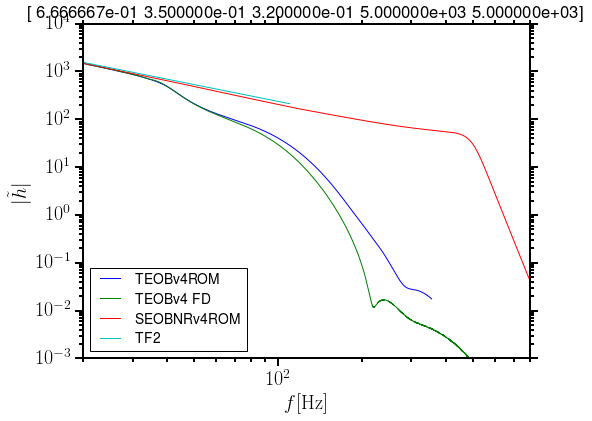

In [10]:
plt.loglog(fHz_TEOBv4, np.abs(h_TEOBv4), label='TEOBv4ROM')
plt.loglog(fHz_TEOBv4FD, np.abs(h_TEOBv4FD), label='TEOBv4 FD')
plt.loglog(fHz_SEOBNRv4, np.abs(h_SEOBNRv4), label='SEOBNRv4ROM')
plt.loglog(fHz_TF2, np.abs(h_TF2), label='TF2');
plt.legend(loc=3)
plt.title(x)
plt.xlabel(r'$f[\mathrm{Hz}]$')
plt.ylabel(r'$|\tilde h|$')
plt.xlim([20, 800]);
plt.ylim([1e-3, 1e4]);

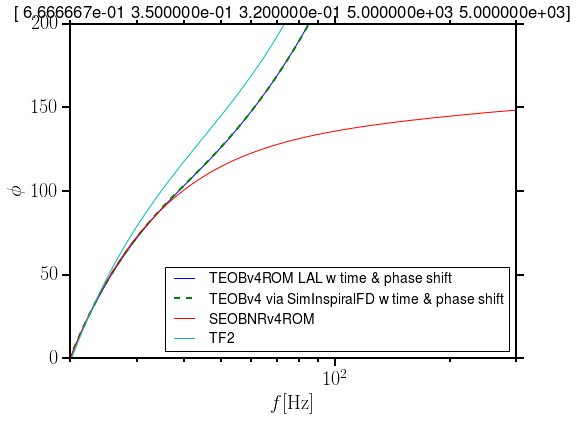

In [11]:
plt.semilogx(fHz_TEOBv4, np.unwrap(np.angle(h_TEOBv4)) + 2.1*fHz_TEOBv4 - 42, label='TEOBv4ROM LAL w time \& phase shift')
plt.semilogx(fHz_TEOBv4FD, np.unwrap(np.angle(h_TEOBv4FD)) + 1.76*fHz_TEOBv4FD + 113, 'g--', lw=2, label='TEOBv4 via SimInspiralFD  w time \& phase shift')
plt.semilogx(fHz_SEOBNRv4, np.unwrap(np.angle(h_SEOBNRv4)), 'r-', label='SEOBNRv4ROM')
plt.semilogx(fHz_TF2, np.unwrap(np.angle(h_TF2)), 'c-', label='TF2');
plt.legend(loc=4)
plt.title(x)
plt.xlabel(r'$f[\mathrm{Hz}]$')
plt.ylabel(r'$\phi$')
plt.xlim([20, 300]);
plt.ylim([0, 200]);

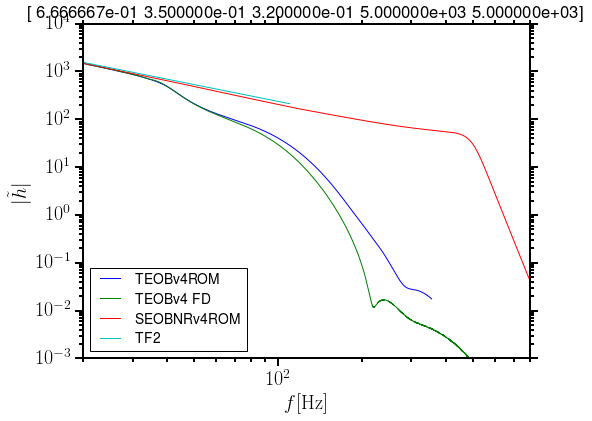

In [12]:
# There is some artefact : TEOBv4ROM should use a parameter dependent BNS merger cutoff frequency
# FIXME: Somehow this is not quite enough!
# The amplitude is very different between the surrogate and the FFT of the TD model - do they agree well in the TD for these parameters?
plt.loglog(fHz_TEOBv4, np.abs(h_TEOBv4), label='TEOBv4ROM')
plt.loglog(fHz_TEOBv4FD, np.abs(h_TEOBv4FD), label='TEOBv4 FD')
plt.loglog(fHz_SEOBNRv4, np.abs(h_SEOBNRv4), label='SEOBNRv4ROM')
plt.loglog(fHz_TF2, np.abs(h_TF2), label='TF2');
plt.legend(loc=3)
plt.title(x)
plt.xlabel(r'$f[\mathrm{Hz}]$')
plt.ylabel(r'$|\tilde h|$')
plt.xlim([20, 800]);
plt.ylim([1e-3, 1e4]);

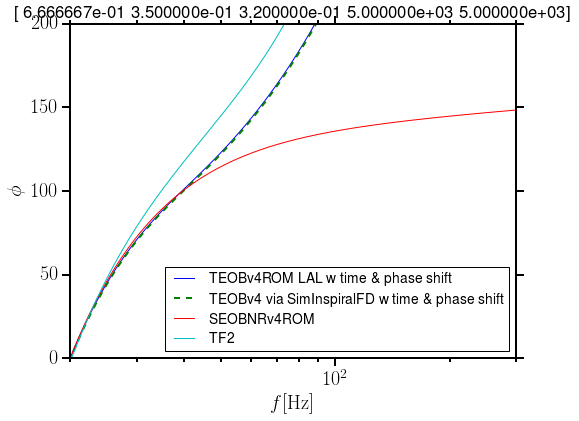

In [13]:
plt.semilogx(fHz_TEOBv4, np.unwrap(np.angle(h_TEOBv4)) + 2*fHz_TEOBv4 - 40, label='TEOBv4ROM LAL w time \& phase shift')
plt.semilogx(fHz_TEOBv4FD, np.unwrap(np.angle(h_TEOBv4FD)) + 1.66*fHz_TEOBv4FD + 114, 'g--', lw=2, label='TEOBv4 via SimInspiralFD  w time \& phase shift')
plt.semilogx(fHz_SEOBNRv4, np.unwrap(np.angle(h_SEOBNRv4)), 'r-', label='SEOBNRv4ROM')
plt.semilogx(fHz_TF2, np.unwrap(np.angle(h_TF2)), 'c-', label='TF2');
plt.legend(loc=4)
plt.title(x)
plt.xlabel(r'$f[\mathrm{Hz}]$')
plt.ylabel(r'$\phi$')
plt.xlim([20, 300]);
plt.ylim([0, 200]);

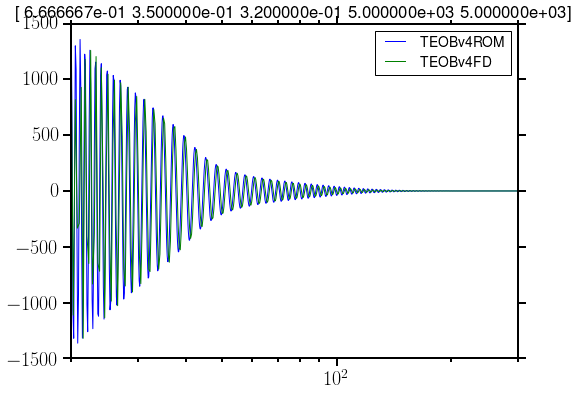

In [14]:
plt.semilogx(fHz_TEOBv4, np.real(h_TEOBv4 * np.exp(1j*(+2.0*fHz_TEOBv4 - 40))), label='TEOBv4ROM');
plt.semilogx(fHz_TEOBv4FD, np.real(h_TEOBv4FD * np.exp(1j*(+1.66*fHz_TEOBv4FD + 114))), label='TEOBv4FD');
#plt.semilogx(fHz_SEOBNRv4, np.real(h_SEOBNRv4), label='SEOBNRv4ROM');
#plt.semilogx(fHz_TF2, h_TF2.real, label='TF2');
plt.legend()
plt.title(x)
plt.xlim([20, 300]);

## Tests for very low frequency regime (without the TD EOB)

For a BNS, we transition between pure TF2 and TF2 + the surrogate around 20Hz.

In [4]:
x = np.array([1.0/1.5, 0.35, 0.32, 1.0, 1.0])
x = np.array([1.0/1.5, 0.35, 0.32, 5000.0, 5000.0])

In [6]:
q = 1.0/x[0]
chi1 = x[1]
chi2 = x[2]
lambda1 = x[3]
lambda2 = x[4]

Mtot = 2.0
fLow = 10.0 # I won't go below this with small df, so that my laptop does not explode
fHigh = 2048.0 # we'll cut off BBH merger, but that's OK
phiRef = 0.0
fRef = fLow
distance, inclination = 1, 0
deltaF = 0.000244 # value chosen by SimInspiralFD

In [7]:
# SEOBNRv4ROM
m1 = q/(1.0+q)*Mtot
m2 = 1.0/(1.0+q)*Mtot
m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max = m1*lal.MSUN_SI, m2*lal.MSUN_SI, chi1, chi2, lambda1, lambda2, -1

hpSEOBNRv4, hcSEOBNRv4 = LS.SimIMRSEOBNRv4ROM(phiRef, deltaF, fLow, fHigh, fRef, distance, inclination, 
                m1SI, m2SI, chi1, chi2, nk_max)

fHz_SEOBNRv4 = np.arange(hpSEOBNRv4.data.length)*hpSEOBNRv4.deltaF
h_SEOBNRv4 = hpSEOBNRv4.data.data + 1j*hcSEOBNRv4.data.data

debugging:
    
    lldb lalsim-inspiral    
    process launch -- -a SEOBNRv4T_surrogate --spin2z 0.4 --tidal-lambda1 -0.9 --m1 1.4 --m2 1.42 -D freq --f-min 10 -F

In [8]:
# SEOBNRv4T_surrogate
m1 = q/(1.0+q)*Mtot
m2 = 1.0/(1.0+q)*Mtot
m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max = m1*lal.MSUN_SI, m2*lal.MSUN_SI, chi1, chi2, lambda1, lambda2, -1

hpTEOBv4, hcTEOBv4 = LS.SimIMRSEOBNRv4TSurrogate(phiRef, deltaF, fLow, fHigh, fRef, distance, inclination, 
                m1SI, m2SI, chi1, chi2, lambda1, lambda2)

fHz_TEOBv4 = np.arange(hpTEOBv4.data.length)*hpTEOBv4.deltaF
h_TEOBv4 = hpTEOBv4.data.data + 1j*hcTEOBv4.data.data

In [9]:
# TaylorF2
LALpars = lal.CreateDict()
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1(LALpars, lambda1)
lalsimulation.SimInspiralWaveformParamsInsertTidalLambda2(LALpars, lambda2)

hpTF2 = LS.SimInspiralTaylorF2(phiRef, deltaF,
                                      m1SI, m2SI, 
                                      chi1, chi2,
                                      fLow, fHigh, fRef, distance, LALpars)
# Compute the two polarizations
cfac = cos(inclination)
pfac = 0.5 * (1.0 + cfac**2)

hpTF2_data = pfac * hpTF2.data.data
hcTF2_data = -1j*cfac * hpTF2.data.data
h_TF2 = hpTF2_data +1j*hcTF2_data
fHz_TF2 = np.arange(hpTF2.data.length)*hpTF2.deltaF

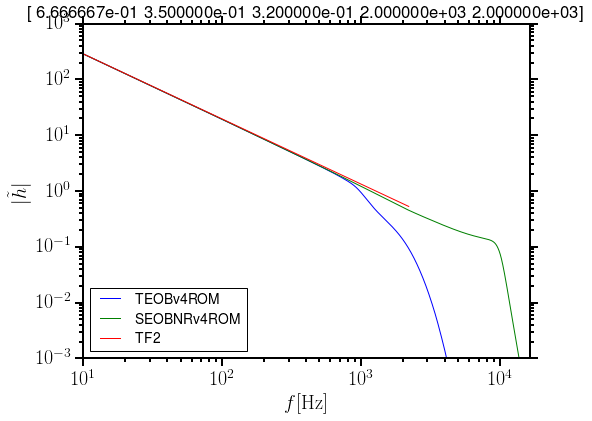

In [23]:
plt.loglog(fHz_TEOBv4, np.abs(h_TEOBv4), label='TEOBv4ROM')
plt.loglog(fHz_SEOBNRv4, np.abs(h_SEOBNRv4), label='SEOBNRv4ROM')
plt.loglog(fHz_TF2, np.abs(h_TF2), label='TF2');
plt.legend(loc=3)
plt.title(x)
plt.xlabel(r'$f[\mathrm{Hz}]$')
plt.ylabel(r'$|\tilde h|$')
plt.xlim([fLow, 16384]);
plt.ylim([1e-3, 1e3]);

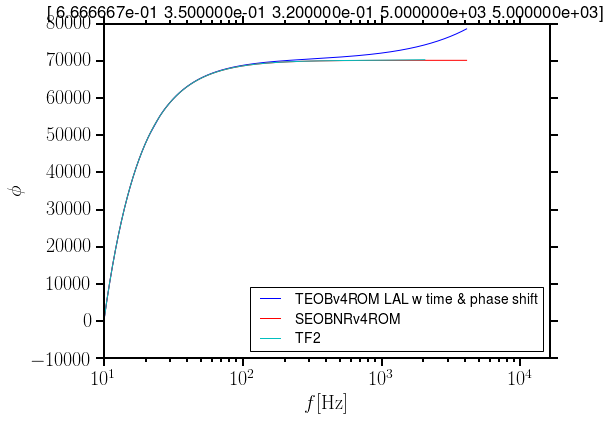

In [10]:
plt.semilogx(fHz_TEOBv4, np.unwrap(np.angle(h_TEOBv4)) + 2.1*fHz_TEOBv4 - 42, label='TEOBv4ROM LAL w time \& phase shift')
plt.semilogx(fHz_SEOBNRv4, np.unwrap(np.angle(h_SEOBNRv4)), 'r-', label='SEOBNRv4ROM')
plt.semilogx(fHz_TF2, np.unwrap(np.angle(h_TF2)), 'c-', label='TF2');
plt.legend(loc=4)
plt.title(x)
plt.xlabel(r'$f[\mathrm{Hz}]$')
plt.ylabel(r'$\phi$')
plt.xlim([fLow, 16384]);

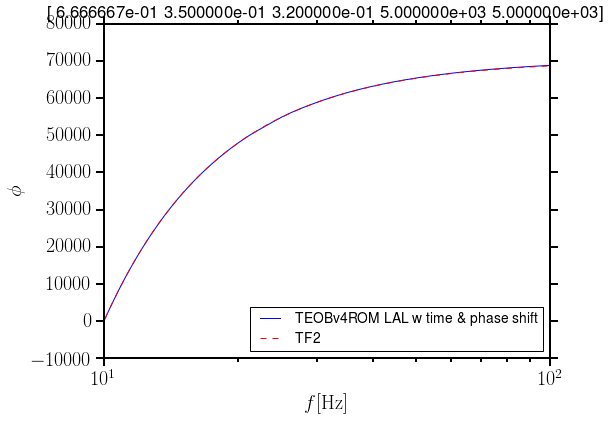

In [21]:
plt.semilogx(fHz_TEOBv4, np.unwrap(np.angle(h_TEOBv4)) + 2.1*fHz_TEOBv4 - 42, label='TEOBv4ROM LAL w time \& phase shift')
plt.semilogx(fHz_TF2, np.unwrap(np.angle(h_TF2)), 'r--', label='TF2');
plt.legend(loc=4)
plt.title(x)
plt.xlabel(r'$f[\mathrm{Hz}]$')
plt.ylabel(r'$\phi$')
plt.xlim([10.0, 100.0]);

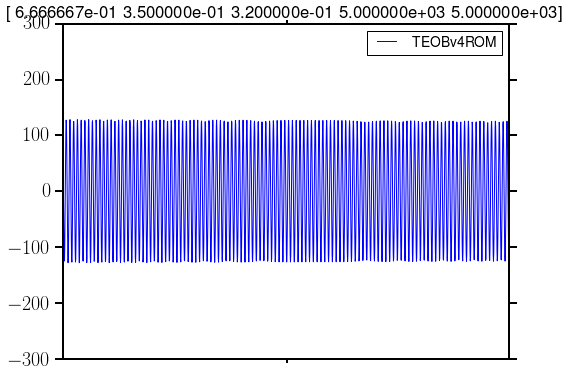

In [19]:
plt.semilogx(fHz_TEOBv4, np.real(h_TEOBv4 * np.exp(1j*(+2.0*fHz_TEOBv4 - 40))), label='TEOBv4ROM');
plt.legend()
plt.title(x)
plt.xlim([19.8, 20.2]);

# Sparse frequency grids

The production grids are now derived in a separate notebook:

    Sparse frequency points for splines

## Low frequency grids

Define a grid on which TaylorF2 should be evaluated for frequencies below the surrogate starting frequency.

One possibility is to choose points to minimize the spline error as in http://iopscience.iop.org/article/10.1088/0264-9381/31/19/195010/pdf, Sec 5.1. There, the following functions for the gridspacing as a function of frequency are derived for the TaylorF2 amplitude and phasing:

$$
\Delta_A(f) \propto f^{31/24}\\
\Delta_\phi(f) \propto f^{17/12}
$$

We can use algorithm 1 with these gridspacings to calculate grids. We tweak the prefactors to give desirable levels of errors in amplitude and phase by checking evaluation on a fine grid.

In [36]:
def Delta_A(Mf):
    return 1.0*Mf**(31.0/24.0) # paper used 0.1

def Delta_phi(Mf):
    return 1.0*Mf**(17.0/12.0) # paper used 0.3

def CSE_points(Mf_min, Mf_max, delta_Mf_fun):
    g = [Mf_min]
    while g[-1] < Mf_max:
        P = g[-1] + delta_Mf_fun(g[-1])
        if P < Mf_max:
            g.append(P)
        else:
            g.append(Mf_max)
    return np.array(g)

In [291]:
Mtot_sec = 2.0 * lal.MTSUN_SI # lowest total mass we consider is 2 Msun
Mf_min, Mf_max = 1.0 * Mtot_sec, 2048.0 * Mtot_sec
# lowest frequency in current surrogate is Mf=0.00021
Mf_max = min(0.00021, Mf_max)

# Errors are larger at boundaries, so let's add a safety factor to surpress this
Mf_min_orig = Mf_min
Mf_max_orig = Mf_max
Mf_min = 0.9*Mf_min
Mf_max = 1.1*Mf_max
print 'Mf_min, Mf_max:', Mf_min, Mf_max

Mf_amp = CSE_points(Mf_min, Mf_max, Delta_A)
Mf_phi = CSE_points(Mf_min, Mf_max, Delta_phi)
print 'Number of points:', len(Mf_amp), len(Mf_phi)

Mf_min, Mf_max: 8.86588384598e-06 0.000231
Number of points: 66 231


In [298]:
np.save("Mf_amp_TF2.npy", Mf_amp)
np.save("Mf_phi_TF2.npy", Mf_phi)

In [292]:
# Example parameters
eta = 0.222
spin1z, spin2z = 0.32, -0.098
lambda1, lambda2 = 2833.0, 3476.0
tbymc, phic = 0.0, 0.0

In [293]:
# Grid for testing interpolation accuracy
g_test = np.linspace(Mf_min, Mf_max, 50000)
print min(np.diff(Mf_amp)), min(np.diff(Mf_phi)), np.diff(g_test)[0]

2.97948336296e-07 6.95995159792e-08 4.4427711785e-09


Amplitude

In [294]:
amp = f2.taylorf2_amp_1pn(Mf_amp, eta)
ampI = spline(Mf_amp, amp, k=3, ext=0)

amp_test = f2.taylorf2_amp_1pn(g_test, eta)
amp_err_abs = ampI(g_test) - amp_test
amp_err_rel = amp_err_abs / amp_test

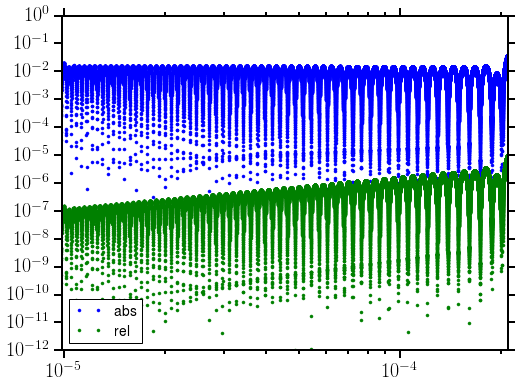

In [295]:
plt.loglog(g_test, np.abs(amp_err_abs), '.', label='abs');
plt.loglog(g_test, np.abs(amp_err_rel), '.', label='rel');
plt.legend(loc=3)
#plt.xlim([Mf_min, Mf_max]);
plt.xlim([Mf_min_orig, Mf_max_orig]);

Phase

In [296]:
phi = f2.taylorf2_phase(Mf_phi, tbymc, phic, eta, spin1z, spin2z, lambda1, lambda2)
phiI = spline(Mf_phi, phi, k=3, ext=0)

phi_test = f2.taylorf2_phase(g_test, tbymc, phic, eta, spin1z, spin2z, lambda1, lambda2)
phi_err_abs = phiI(g_test) - phi_test
phi_err_rel = phi_err_abs / phi_test

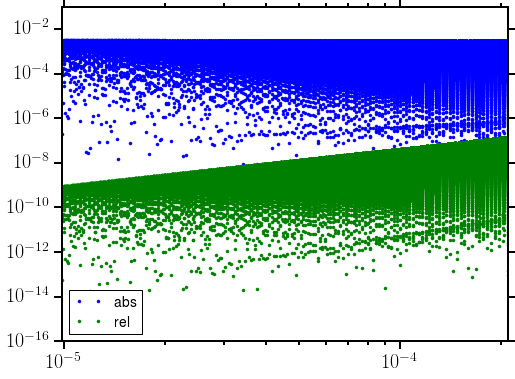

In [297]:
plt.loglog(g_test, np.abs(phi_err_abs), '.', label='abs');
plt.loglog(g_test, np.abs(phi_err_rel), '.', label='rel');
plt.legend(loc=3)
# plt.xlim([Mf_min, Mf_max]);
plt.xlim([Mf_min_orig, Mf_max_orig]);

## Sparse frequency grids for entire range

The 20 point grid used in the surrogate is not sufficient to represent TaylorF2 at low frequency in the surrogate frequency range $Mf \in [0.00021, 0.07]$. 

To solve this problem, we use sparse grids covering the entire frequency range from ET-like starting frequencies to the BNS merger frequency and a bit beyond.

In [40]:
# upper frequency cutoff for a typical BNS
0.07 / Mtot_sec

7105.890523095088

In [56]:
Mtot_sec = 2.0 * lal.MTSUN_SI # lowest total mass we consider is 2 Msun
Mf_min = 1.0 * Mtot_sec # 1Hz starting frequency
Mf_max = 0.07 # upper frequency cutoff used in surrogate of corrections

# Errors are larger at boundaries, so let's add a safety factor to surpress this
Mf_min_orig = Mf_min
Mf_max_orig = Mf_max
Mf_min = 0.9*Mf_min
Mf_max = 1.1*Mf_max
print 'Mf_min, Mf_max:', Mf_min, Mf_max

Mf_amp = CSE_points(Mf_min, Mf_max, Delta_A)
Mf_phi = CSE_points(Mf_min, Mf_max, Delta_phi)
print 'Number of points:', len(Mf_amp), len(Mf_phi)

Mf_min, Mf_max: 8.86588384598e-06 0.077
Number of points: 102 307


In [57]:
np.save("Mf_amp_TF2.npy", Mf_amp)
np.save("Mf_phi_TF2.npy", Mf_phi)

In [42]:
# Example parameters
eta = 0.222
spin1z, spin2z = 0.32, -0.098
lambda1, lambda2 = 2833.0, 3476.0
tbymc, phic = 0.0, 0.0

In [45]:
# Grid for testing interpolation accuracy
g_test = np.linspace(Mf_min, Mf_max, 1000000)
print min(np.diff(Mf_amp)), min(np.diff(Mf_phi)), np.diff(g_test)[0]

2.97948336296e-07 6.95995159792e-08 7.69912111074e-08


Amplitude

In [46]:
amp = f2.taylorf2_amp_1pn(Mf_amp, eta)
ampI = spline(Mf_amp, amp, k=3, ext=0)

amp_test = f2.taylorf2_amp_1pn(g_test, eta)
amp_err_abs = ampI(g_test) - amp_test
amp_err_rel = amp_err_abs / amp_test

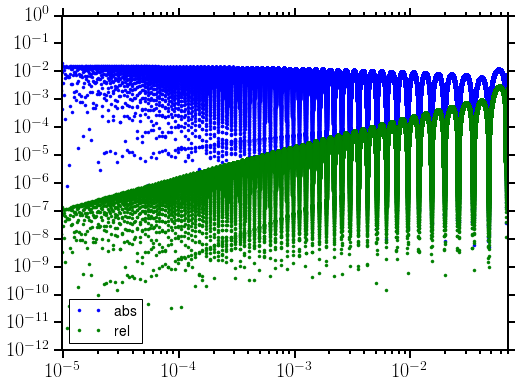

In [47]:
plt.loglog(g_test, np.abs(amp_err_abs), '.', label='abs');
plt.loglog(g_test, np.abs(amp_err_rel), '.', label='rel');
plt.legend(loc=3)
#plt.xlim([Mf_min, Mf_max]);
plt.xlim([Mf_min_orig, Mf_max_orig]);

Phase

In [48]:
phi = f2.taylorf2_phase(Mf_phi, tbymc, phic, eta, spin1z, spin2z, lambda1, lambda2)
phiI = spline(Mf_phi, phi, k=3, ext=0)

phi_test = f2.taylorf2_phase(g_test, tbymc, phic, eta, spin1z, spin2z, lambda1, lambda2)
phi_err_abs = phiI(g_test) - phi_test
phi_err_rel = phi_err_abs / phi_test

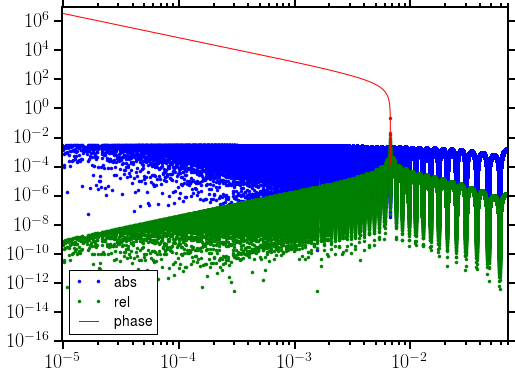

In [53]:
plt.loglog(g_test, np.abs(phi_err_abs), '.', label='abs');
plt.loglog(g_test, np.abs(phi_err_rel), '.', label='rel');
plt.loglog(g_test, -phi_test, label='phase')
plt.legend(loc=3)
# plt.xlim([Mf_min, Mf_max]);
plt.xlim([Mf_min_orig, Mf_max_orig]);

# Timings

For production results see the separate notebook and script:

    * https://github.com/benjaminlackey/gpsurrogate/blob/master/src/TEOB-LAL-implementation/timings/Timing_plots.ipynb
    * https://github.com/benjaminlackey/gpsurrogate/blob/master/src/TEOB-LAL-implementation/timings/timings.py

## Fuctions

We'll use SimInspiralFD so we can compare TD and FD waveforms without additional code

In [4]:
def FD_waveform_test(Mtot, x, approximant, fLow=20.0, fHigh=16384.0, deltaF=0):
    q = 1.0/x[0]
    chi1 = x[1]
    chi2 = x[2]
    lambda1 = x[3]
    lambda2 = x[4]
    
    phiRef, fRef = 0.0, fLow
    distance, inclination = 1.0, 0.0
    
    m1 = q/(1.0+q)*Mtot
    m2 = 1.0/(1.0+q)*Mtot
    m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max = m1*lal.MSUN_SI, m2*lal.MSUN_SI, chi1, chi2, lambda1, lambda2, -1

    longAscNodes, eccentricity, meanPerAno = 0,0,0

    LALpars = lal.CreateDict()
    LS.SimInspiralWaveformParamsInsertTidalLambda1(LALpars, lambda1)
    LS.SimInspiralWaveformParamsInsertTidalLambda2(LALpars, lambda2)

    # Nyquist frequency is set by fHigh
    # Can set deltaF = 0 to figure out required frequency spacing; the chosen deltaF depends on fLow
    
    # Documentation from LALSimInspiral.c
    #
    #  * This routine can generate TD approximants and transform them into the frequency domain.
    #  * Waveforms are generated beginning at a slightly lower starting frequency and tapers
    #  * are put in this early region so that the waveform smoothly turns on.
    #  *
    #  * If an FD approximant is used, this routine applies tapers in the frequency domain
    #  * between the slightly-lower frequency and the requested f_min.  Also, the phase of the
    #  * waveform is adjusted to introduce a time shift.  This time shift should allow the
    #  * resulting waveform to be Fourier transformed into the time domain without wrapping
    #  * the end of the waveform to the beginning.
    #  *
    #  * This routine assumes that f_max is the Nyquist frequency of a corresponding time-domain
    #  * waveform, so that deltaT = 0.5 / f_max.  If deltaF is set to 0 then this routine computes
    #  * a deltaF that is small enough to represent the Fourier transform of a time-domain waveform.
    #  * If deltaF is specified but f_max / deltaF is not a power of 2, and the waveform approximant
    #  * is a time-domain approximant, then f_max is increased so that f_max / deltaF is the next
    #  * power of 2.  (If the user wishes to discard the extra high frequency content, this must
    #  * be done separately.)
    
    hp, hc = LS.SimInspiralFD(m1SI, m2SI,
                     0.0, 0.0, chi1,
                     0.0, 0.0, chi2,
                     distance, inclination, phiRef, 
                     longAscNodes, eccentricity, meanPerAno, 
                     deltaF,
                     fLow, fHigh, fRef,
                     LALpars,
                     approximant)

    fHz = np.arange(hp.data.length)*hp.deltaF
    h = hp.data.data + 1j*hc.data.data
    
    return hp.deltaF

In [5]:
def _template_func(setup, func):
    """Create a timer function. Used if the "statement" is a callable."""
    def inner(_it, _timer, _func=func):
        setup()
        _t0 = _timer()
        for _i in _it:
            retval = _func()
        _t1 = _timer()
        return _t1 - _t0, retval
    return inner

def timeit_ipython(stmt, number=0, verbose=False):
    """
    Replicate ipython's %timeit functionality in a function
    Code lifted from https://github.com/ipython/ipython/blob/ea199a6ddc6cd80f46d0c106c7c7db95ebadc985/IPython/core/magic.py#L1811
    
    Added feature: grab return value of code
    
    stmt: string containing python code to time
    number <N>: execute the given statement <N> times in a loop (Default: 0 to determine automatically)
    
    Returns: 
      number of loops
      number of evaluations in loop
      best timing in seconds
      time taken to compile the code
      return value of code for best timing
    """
    import timeit
    import math
    from time import clock

    units = [u"s", u"ms",u'us',"ns"]
    scaling = [1, 1e3, 1e6, 1e9]
    timefunc = timeit.default_timer
    repeat = timeit.default_repeat

    timer = timeit.Timer(timer=timefunc)

    # Modify the function template to return the result of the code to be timed
    template_w_return = """
def inner(_it, _timer%(init)s):
    %(setup)s
    _t0 = _timer()
    for _i in _it:
         %(stmt)s
    _t1 = _timer()
    return _t1 - _t0, retval
"""

#     src = timeit.template % {'stmt': timeit.reindent(stmt, 8), 'setup': "pass"}
    src = template_w_return % {'stmt': timeit.reindent('retval = '+stmt, 8), 'setup': "pass", 'init':"" }

    # Track compilation time so it can be reported if too long
    # Minimum time above which compilation time will be reported
    tc_min = 0.1

    t0 = clock()
    code = compile(src, "timeit_ipython", "exec")
    tc = clock()-t0

    user_ns = globals() # grab global fuction definitions and variables
    ns = {}
    exec code in user_ns, ns
    timer.inner = ns["inner"]

    if number == 0:
        # determine number so that 0.2 <= total time < 2.0
        number = 1
        for i in range(1, 10):
            t, ret = timer.timeit(number)
            if t >= 0.2:
                break
    number *= 10

    timings, rets = np.array(timer.repeat(repeat, number)).T
    best = min(timings) / number
    retval_best = rets[np.argmin(timings)]

    if best > 0.0 and best < 1000.0:
        order = min(-int(math.floor(math.log10(best)) // 3), 3)
    elif best >= 1000.0:
        order = 0
    else:
        order = 3
        
    if verbose:
        precision = 3
        print u"%d loops, best of %d: %.*g %s per loop" % (number, repeat,
                                                          precision,
                                                          best * scaling[order],
                                                          units[order])
        if tc > tc_min:
            print "Compiler time: %.2f s" % tc

    return number, repeat, best, tc, retval_best

In [6]:
Mtot = 2.0
x = np.array([1.0/1.5, 0.35, 0.32, 2000.0, 2000.0])

In [14]:
timeit_ipython("FD_waveform_test(Mtot, x, LS.SEOBNRv4T_surrogate, fLow=20.0, fHigh=2048.0, deltaF=0.1)")

(10, 3, 0.013956499099731446, 7.899999999994023e-05, 0.10000000000000001)

In [8]:
timeit_ipython("FD_waveform_test(Mtot, x, LS.SEOBNRv4T_surrogate, fLow=20.0, fHigh=2048.0, deltaF=0)")

(10, 3, 0.91059241294860838, 7.2000000000072e-05, 0.001953125)

In [8]:
x = np.array([1.0/1.5, 0.35, 0.32, 0.0, 0.0])
timeit_ipython("FD_waveform_test(Mtot, x, LS.SEOBNRv4_ROM, fLow=20.0, fHigh=2048.0, deltaF=0.1)")

(10, 3, 0.0075017929077148436, 7.699999999988272e-05, 0.10000000000000001)

In [11]:
x = np.array([1.0/1.5, 0.35, 0.32, 0.0, 0.0])
timeit_ipython("FD_waveform_test(Mtot, x, LS.SEOBNRv4_ROM, fLow=11.0, fHigh=2048.0, deltaF=0.1)")

(10, 3, 0.0071089982986450194, 7.50000000002693e-05, 0.10000000000000001)

In [16]:
timeit_ipython("FD_waveform_test(Mtot, x, LS.SEOBNRv4T_surrogate, fLow=10.0, fHigh=2048.0, deltaF=0.1)")

(10, 3, 0.014206194877624511, 7.800000000024454e-05, 0.10000000000000001)

In [18]:
timeit_ipython("FD_waveform_test(Mtot, x, LS.SEOBNRv4T_surrogate, fLow=10.0, fHigh=2048.0, deltaF=0)")

(10, 3, 1.3445730209350586, 7.899999999949614e-05, 0.000244140625)

In [58]:
timeit_ipython("FD_waveform_test(Mtot, x, LS.TEOBv4, fLow=100.0, fHigh=2048.0, deltaF=0)")

(10, 3, 7.0107702970504757, 9.999999997489795e-05, 0.25)

In [59]:
timeit_ipython("FD_waveform_test(Mtot, x, LS.TEOBv4, fLow=50.0, fHigh=2048.0, deltaF=0)")

(10, 3, 27.710168194770812, 8.09999999091815e-05, 0.03125)

In [ ]:
timeit_ipython("FD_waveform_test(Mtot, x, LS.TEOBv4, fLow=20.0, fHigh=2048.0, deltaF=0)")

(10, 3, 317.80276520252227, 7.899999991423101e-05, 0.00390625)

In [7]:
f_mins = np.arange(10.0, 100.0, 5)

In [8]:
Mtot = 2*1.35
x = np.array([1.0/1.5, 0.35, -0.12, 2000.0, 2750.0])
tim_sur = np.array([timeit_ipython("FD_waveform_test(Mtot, x, LS.SEOBNRv4T_surrogate, fLow=%f, fHigh=2048.0, deltaF=0)" %(f_min)) 
 for f_min in f_mins])

In [9]:
Mtot = 2*1.35
x = np.array([1.0/1.5, 0.35, -0.12, 2000.0, 2750.0])
tim_TF2 = np.array([timeit_ipython("FD_waveform_test(Mtot, x, LS.TaylorF2, fLow=%f, fHigh=2048.0, deltaF=0)" %(f_min)) 
 for f_min in f_mins])

In [10]:
Mtot = 2*1.35
x = np.array([1.0/1.5, 0.35, -0.12, 0.0, 0.0])
tim_SEOBNRv4_ROM = np.array([timeit_ipython("FD_waveform_test(Mtot, x, LS.SEOBNRv4_ROM, fLow=%f, fHigh=2048.0, deltaF=0)" %(f_min)) 
 for f_min in f_mins])

In [11]:
Mtot = 2*1.35
x = np.array([1.0/1.5, 0.35, -0.12, 0.0, 2500.0])
tim_SEOBNRv4_ROM_NRTidal = np.array([timeit_ipython("FD_waveform_test(Mtot, x, LS.SEOBNRv4_ROM_NRTidal, fLow=%f, fHigh=2048.0, deltaF=0)" %(f_min)) 
 for f_min in f_mins])

In [12]:
Mtot = 2*1.35
x = np.array([1.0/1.5, 0.35, -0.12, 0.0, 0.0])
tim_IMRPhenomD = np.array([timeit_ipython("FD_waveform_test(Mtot, x, LS.IMRPhenomD, fLow=%f, fHigh=2048.0, deltaF=0)" %(f_min)) 
 for f_min in f_mins])

In [13]:
Mtot = 2*1.35
x = np.array([1.0/1.5, 0.35, -0.12, 0.0, 2500.0])
tim_IMRPhenomD_NRTidal = np.array([timeit_ipython("FD_waveform_test(Mtot, x, LS.IMRPhenomD_NRTidal, fLow=%f, fHigh=2048.0, deltaF=0)" %(f_min)) 
 for f_min in f_mins])

In [14]:
f_mins_2 = f_mins[2:]

In [15]:
tim_SEOBNRv4T = np.array([[  1.000000e+01,   3.000000e+00,   5.838633e+02,   7.500000e-05,   3.906250e-03],
       [  1.000000e+01,   3.000000e+00,   2.964636e+02,   9.400000e-05,   7.812500e-03],
       [  1.000000e+01,   3.000000e+00,   1.768064e+02,   8.600000e-05,   7.812500e-03],
       [  1.000000e+01,   3.000000e+00,   1.178355e+02,   9.099999e-05,   1.562500e-02],
       [  1.000000e+01,   3.000000e+00,   8.195316e+01,   9.199999e-05,   1.562500e-02],
       [  1.000000e+01,   3.000000e+00,   6.162256e+01,   1.140000e-04,   3.125000e-02],
       [  1.000000e+01,   3.000000e+00,   4.762087e+01,   1.130000e-04,   3.125000e-02],
       [  1.000000e+01,   3.000000e+00,   3.846191e+01,   8.600000e-05,   6.250000e-02],
       [  1.000000e+01,   3.000000e+00,   3.123066e+01,   8.700000e-05,   6.250000e-02],
       [  1.000000e+01,   3.000000e+00,   2.660933e+01,   1.050000e-04,   6.250000e-02],
       [  1.000000e+01,   3.000000e+00,   2.307281e+01,   1.040000e-04,   1.250000e-01],
       [  1.000000e+01,   3.000000e+00,   2.028036e+01,   1.250000e-04,   1.250000e-01],
       [  1.000000e+01,   3.000000e+00,   1.777694e+01,   8.600000e-05,   1.250000e-01],
       [  1.000000e+01,   3.000000e+00,   1.592490e+01,   1.440000e-04,   1.250000e-01],
       [  1.000000e+01,   3.000000e+00,   1.452376e+01,   8.600000e-05,   1.250000e-01],
       [  1.000000e+01,   3.000000e+00,   1.307074e+01,   8.800000e-05,   2.500000e-01]])

In [11]:
f_mins_2 = f_mins[2:]
Mtot = 2*1.35
x = np.array([1.0/1.5, 0.35, -0.12, 2000.0, 2750.0])
tim_SEOBNRv4T = np.array([timeit_ipython("FD_waveform_test(Mtot, x, LS.TEOBv4, fLow=%f, fHigh=2048.0, deltaF=0)" %(f_min)) 
 for f_min in f_mins_2])

Save timing data

In [16]:
import h5py
fp = h5py.File('timing.hdf5', 'w')
fp.create_dataset('f_mins', data=f_mins)
fp.create_dataset('tim_SEOBNRv4T', data=tim_SEOBNRv4T) # currently drops the lowest two frequencies
fp.create_dataset('tim_sur', data=tim_sur)
fp.create_dataset('tim_TF2', data=tim_TF2)
fp.create_dataset('tim_SEOBNRv4_ROM', data=tim_SEOBNRv4_ROM)
fp.create_dataset('tim_SEOBNRv4_ROM_NRTidal', data=tim_SEOBNRv4_ROM_NRTidal)
fp.create_dataset('tim_IMRPhenomD_NRTidal', data=tim_IMRPhenomD_NRTidal)
fp.create_dataset('tim_IMRPhenomD', data=tim_IMRPhenomD)

x = np.array([1.0/1.5, 0.35, -0.12, 0.0, 2500.0])
fp.create_dataset('x', data=x) # lambda1,2 = 0 for BHs
fp.close()

In [49]:
# https://scipy.github.io/old-wiki/pages/Cookbook/Matplotlib/UsingTex

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

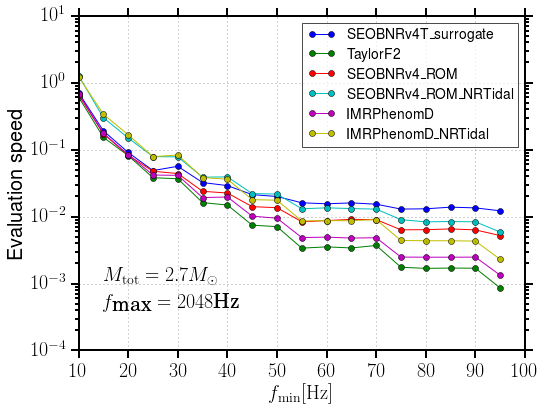

In [56]:
#plt.semilogy(f_mins_2, tim_SEOBNRv4T.T[2], 'o-', label='SEOBNRv4T');
plt.semilogy(f_mins, tim_sur.T[2], 'o-', label='SEOBNRv4T\_surrogate');
plt.semilogy(f_mins, tim_TF2.T[2], 'o-', label='TaylorF2');
plt.semilogy(f_mins, tim_SEOBNRv4_ROM.T[2], 'o-', label='SEOBNRv4\_ROM');
plt.semilogy(f_mins, tim_SEOBNRv4_ROM_NRTidal.T[2], 'o-', label='SEOBNRv4\_ROM\_NRTidal');
plt.semilogy(f_mins, tim_IMRPhenomD.T[2], 'o-', label='IMRPhenomD');
plt.semilogy(f_mins, tim_IMRPhenomD_NRTidal.T[2], 'o-', label='IMRPhenomD\_NRTidal');
plt.grid(alpha=0.7)
plt.legend(framealpha=0.7);
plt.text(15, 1e-3, r'$M_\mathrm{tot} = 2.7M_\odot$',
         horizontalalignment='left', fontsize=20)
plt.text(15, 4e-4, r'$f_\textrm{max} = 2048\textrm{Hz}$',
         horizontalalignment='left', fontsize=20)

plt.xlabel(r'$f_\mathrm{min}[\mathrm{Hz}]$')
plt.ylabel(r'Evaluation speed');
plt.savefig('Models_timings.pdf')
plt.savefig('Models_timings.png')

Once timing data for SEOBNRv4T becomes available for 10, 15Hz, remake this plot with the added points.

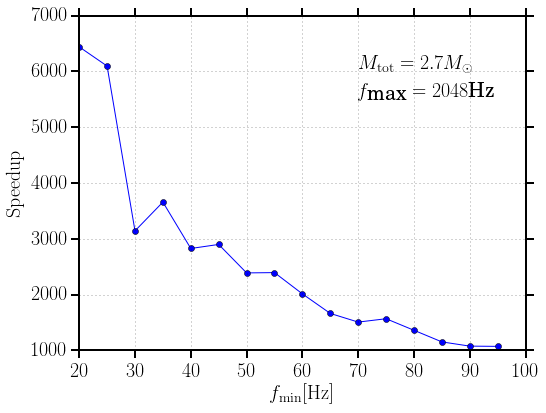

In [55]:
plt.plot(f_mins_2, tim_SEOBNRv4T.T[2] / tim_sur.T[2][2:], 'o-', label='SEOBNRv4T');
plt.xlabel(r'$f_\mathrm{min}[\mathrm{Hz}]$')
plt.ylabel(r'$\mathrm{Speedup}$')
plt.grid(alpha=0.7)

plt.text(70, 6000, r'$M_\mathrm{tot} = 2.7M_\odot$',
         horizontalalignment='left', fontsize=20)
plt.text(70, 5500, r'$f_\textrm{max} = 2048\textrm{Hz}$',
         horizontalalignment='left', fontsize=20);
plt.savefig('SEOBNRv4T_surrogate_speedup.pdf')
plt.savefig('SEOBNRv4T_surrogate_speedup.png')

Try linear splines.

## Tests

In [28]:
x = np.array([1.0/1.5, 0.35, 0.32, 5000.0, 5000.0])

In [29]:
Mtot=40.0

In [90]:
%timeit FD_waveform_test(Mtot, x, LS.TEOBv4, fHigh=16384.0)

1 loop, best of 3: 7.4 s per loop


In [9]:
%timeit FD_waveform_test(Mtot, x, LS.SEOBNRv4T_surrogate, fHigh=16384.0)

100 loops, best of 3: 13.5 ms per loop


In [10]:
%timeit FD_waveform_test(Mtot, x, LS.TEOBv4, fHigh=2048.0)

1 loop, best of 3: 7.29 s per loop


In [11]:
%timeit FD_waveform_test(Mtot, x, LS.SEOBNRv4T_surrogate, fHigh=2048.0)

100 loops, best of 3: 13.4 ms per loop


In [14]:
x = np.array([1.0/1.5, 0.35, 0.32, 0.0, 0.0]) # need to set tidal deformabilities to zero
%timeit FD_waveform_test(Mtot, x, LS.SEOBNRv4_ROM, fHigh=2048.0)

100 loops, best of 3: 7.52 ms per loop


In [13]:
%timeit FD_waveform_test(Mtot, x, LS.TaylorF2, fHigh=2048.0)

100 loops, best of 3: 6.75 ms per loop


In [23]:
SEOBNRv4TSur_res = %timeit -o FD_waveform_test(Mtot, x, LS.SEOBNRv4T_surrogate, fHigh=2048.0)

100 loops, best of 3: 13.6 ms per loop


XLAL Error - SurrogateCore (LALSimIMRSEOBNRv4TSurrogate.c:780): Starting frequency Mflow=6.38095e-05 is smaller than lowest frequency in ROM Mf=0.00021.

In [30]:
def timeit_FD_waveform(Mtot, x, LS_approximant, fLow=20.0, fHigh=2048.0, deltaF=0.1):
    code = "FD_waveform_test(%f, %s, %d, fLow=%f, fHigh=%f, deltaF=%f)" % (Mtot, tuple(x), LS_approximant, fLow, fHigh, deltaF)
    print code
    number, repeat, best, tc, retval_best = timeit_ipython(code)
    print number, repeat, best, tc, retval_best
    return best, retval_best

In [31]:
Mtot = 2*1.35

In [32]:
x = np.array([1.0/1.5, 0.35, 0.32, 5000.0, 5000.0])

In [158]:
timeit_FD_waveform(Mtot, x, LS.SEOBNRv4T_surrogate, fLow=20.0, fHigh=2048.0, deltaF=0)

FD_waveform_test(2.700000, (0.66666666666666663, 0.34999999999999998, 0.32000000000000001, 0.0, 0.0), 60, fLow=20.000000, fHigh=2048.000000, deltaF=0.000000)


(0.39412889480590818, 0.00390625)

In [159]:
timeit_FD_waveform(Mtot, x, LS.SEOBNRv4_ROM, fLow=20.0, fHigh=2048.0, deltaF=0)

FD_waveform_test(2.700000, (0.66666666666666663, 0.34999999999999998, 0.32000000000000001, 0.0, 0.0), 58, fLow=20.000000, fHigh=2048.000000, deltaF=0.000000)


(0.66624889373779295, 0.00390625)

In [165]:
timeit_FD_waveform(Mtot, x, LS.TaylorF2, fLow=20.0, fHigh=2048.0, deltaF=0)

FD_waveform_test(2.700000, (0.66666666666666663, 0.34999999999999998, 0.32000000000000001, 0.0, 0.0), 5, fLow=20.000000, fHigh=2048.000000, deltaF=0.000000)
10 3 0.56693611145 0.000113000000056 0.00390625


(0.56693611145019529, 0.00390625)

In [161]:
timing_TEOBv4 = timeit_FD_waveform(Mtot, x, LS.TEOBv4, fLow=20.0, fHigh=2048.0, deltaF=0)

FD_waveform_test(2.700000, (0.66666666666666663, 0.34999999999999998, 0.32000000000000001, 0.0, 0.0), 51, fLow=20.000000, fHigh=2048.000000, deltaF=0.000000)


In [162]:
timing_TEOBv4 # what unit is this; it should be O(hours)

(106.17409179210662, 0.00390625)

In [ ]:
timeit_FD_waveform(Mtot, x, LS.SEOBNRv4_ROM, fLow=10.0, fHigh=2048.0, deltaF=0)

## memcheck

In [10]:
%%bash
valgrind --leak-check=full -v lalsim-inspiral -a SEOBNRv4T_surrogate --spin2z 0.4 --tidal-lambda1 -0.9 --m1 1.4 --m2 2.5 > out

==57771== Memcheck, a memory error detector
==57771== Copyright (C) 2002-2015, and GNU GPL'd, by Julian Seward et al.
==57771== Using Valgrind-3.11.0.SVN and LibVEX; rerun with -h for copyright info
==57771== Command: lalsim-inspiral -a SEOBNRv4T_surrogate --spin2z 0.4 --tidal-lambda1 -0.9 --m1 1.4 --m2 2.5
==57771== 
--57771-- Valgrind options:
--57771--    --leak-check=full
--57771--    -v
--57771-- Output from sysctl({CTL_KERN,KERN_VERSION}):
--57771--   Darwin Kernel Version 14.5.0: Sun Jun  4 21:40:08 PDT 2017; root:xnu-2782.70.3~1/RELEASE_X86_64
--57771-- Arch and hwcaps: AMD64, LittleEndian, amd64-cx16-lzcnt-rdtscp-sse3-avx-avx2-bmi
--57771-- Page sizes: currently 4096, max supported 4096
--57771-- Valgrind library directory: /usr/local/Cellar/valgrind/HEAD/lib/valgrind
--57771-- /Users/mpuer/master/bin/lalsim-inspiral (rx at 0x100000000, rw at 0x100006000)
--57771--    reading syms   from primary file (12 48)
--57771--    dSYM= /Users/mpuer/master/bin/lalsim-inspiral.dSYM/Conte

There is exactly one memory leak in the code which is what we expect since the surrogate data is loaded and never freeed. Below is a comparison for SEOBNRv4_ROM which has one leak per submodel (3 in total).

In [100]:
%%bash
valgrind --leak-check=full -v lalsim-inspiral -a SEOBNRv4_ROM --spin2z 0.4 --m1 1.4 --m2 2.5 > out2

==53770== Memcheck, a memory error detector
==53770== Copyright (C) 2002-2015, and GNU GPL'd, by Julian Seward et al.
==53770== Using Valgrind-3.11.0.SVN and LibVEX; rerun with -h for copyright info
==53770== Command: lalsim-inspiral -a SEOBNRv4_ROM --spin2z 0.4 --m1 1.4 --m2 2.5
==53770== 
--53770-- Valgrind options:
--53770--    --leak-check=full
--53770--    -v
--53770-- Output from sysctl({CTL_KERN,KERN_VERSION}):
--53770--   Darwin Kernel Version 14.5.0: Sun Jun  4 21:40:08 PDT 2017; root:xnu-2782.70.3~1/RELEASE_X86_64
--53770-- Arch and hwcaps: AMD64, LittleEndian, amd64-cx16-lzcnt-rdtscp-sse3-avx-avx2-bmi
--53770-- Page sizes: currently 4096, max supported 4096
--53770-- Valgrind library directory: /usr/local/Cellar/valgrind/HEAD/lib/valgrind
--53770-- /Users/mpuer/master/bin/lalsim-inspiral (rx at 0x100000000, rw at 0x100006000)
--53770--    reading syms   from primary file (12 48)
--53770--    dSYM= /Users/mpuer/master/bin/lalsim-inspiral.dSYM/Contents/Resources/DWARF/lalsim-i

## Callgrind

make -j install CFLAGS='-gp'

In [15]:
%%bash
valgrind --tool=callgrind -v lalsim-inspiral -a SEOBNRv4T_surrogate --spin2z 0.4 --tidal-lambda1 -0.9 --m1 1.4 --m2 2.5 > out

==82169== Callgrind, a call-graph generating cache profiler
==82169== Copyright (C) 2002-2015, and GNU GPL'd, by Josef Weidendorfer et al.
==82169== Using Valgrind-3.11.0.SVN and LibVEX; rerun with -h for copyright info
==82169== Command: lalsim-inspiral -a SEOBNRv4T_surrogate --spin2z 0.4 --tidal-lambda1 -0.9 --m1 1.4 --m2 2.5
==82169== 
--82169-- Valgrind options:
--82169--    --tool=callgrind
--82169--    -v
--82169-- Output from sysctl({CTL_KERN,KERN_VERSION}):
--82169--   Darwin Kernel Version 14.5.0: Sun Jun  4 21:40:08 PDT 2017; root:xnu-2782.70.3~1/RELEASE_X86_64
--82169-- Arch and hwcaps: AMD64, LittleEndian, amd64-cx16-lzcnt-rdtscp-sse3-avx-avx2-bmi
--82169-- Page sizes: currently 4096, max supported 4096
--82169-- Valgrind library directory: /usr/local/Cellar/valgrind/HEAD/lib/valgrind
==82169== For interactive control, run 'callgrind_control -h'.
--82169-- /Users/mpuer/master/bin/lalsim-inspiral (rx at 0x100000000, rw at 0x100006000)
--82169--    reading syms   from primary

http://valgrind.org/docs/manual/cl-manual.html

In [16]:
%%bash
callgrind_annotate callgrind.out.82169 --inclusive=yes --tree=both

--------------------------------------------------------------------------------
Profile data file 'callgrind.out.82169' (creator: callgrind-3.11.0.SVN)
--------------------------------------------------------------------------------
I1 cache: 
D1 cache: 
LL cache: 
Timerange: Basic block 0 - 526862478
Trigger: Program termination
Profiled target:  lalsim-inspiral -a SEOBNRv4T_surrogate --spin2z 0.4 --tidal-lambda1 -0.9 --m1 1.4 --m2 2.5 (PID 82169, part 1)
Events recorded:  Ir
Events shown:     Ir
Event sort order: Ir
Thresholds:       99
Include dirs:     
User annotated:   
Auto-annotation:  off

--------------------------------------------------------------------------------
           Ir 
--------------------------------------------------------------------------------
2,860,899,567  PROGRAM TOTALS

--------------------------------------------------------------------------------
           Ir  file:function
---------------------------------------------------------------------------

This is a bit hard to parse without a graphical tool which one would need to compile for OS X

## iprofiler

### Old code

iprofiler and Instruments sample the process at a designated interval, so it can't know the total number of calls made to particular functions.

In [23]:
%%bash

iprofiler -I 40us -timeprofiler -activitymonitor -leaks -counters \
-d ./ \
/Users/mpuer/master/bin/lalsim-inspiral \
-a SEOBNRv4T_surrogate  --m1 1.3 --m2 1.5 --spin1z 0.12 --spin2z 0.4 \
--tidal-lambda1 1520.0 --tidal-lambda1 2472.0 > out

open ./lalsim-inspiral.dtps

<img src="trace.png">

Allocating the workspace gsl_vector of length 5 only once and passing a pointer to the kernel from the generator sped up the surrogate generation from 257.5ms to 39.4ms in the example above.

<img src="trace_opt.png">

<img src="trace_opt2.png">

Breakdown of costs:
  * gp_predict: 40%
    - kernel: 74%
      - cblas_dnrm2: 35%
      - gsl_vector_div: 22%
      - memcpy, other gsl operations
    - exp: 8%
    - gsl operations
  * sincos: 25%
  * _platform_bzero: 12% (what is this?)
  * gsl spline evaluation: 10%

### Alternative: profile via a python script; here Instruments does not get any information on the calls, so the callgraph is not useful.

In [13]:
%%bash
iprofiler -timeprofiler -activitymonitor -leaks /usr/local/bin/ipython /Users/mpuer/Documents/gpsurrogate/src/TEOB-LAL-implementation/test_FD_generation.ipy
open /Users/mpuer/Documents/gpsurrogate/src/TEOB-LAL-implementation/ipython.dtps

]0;IPython: src/TEOB-LAL-implementation10 loops, best of 3: 46 ms per loop
iprofiler: Preparing recording resources
iprofiler: Profiling process 73909 (ipython) for 10 seconds
iprofiler: Target pid has died. Ending recording.
iprofiler: Saving session...
iprofiler: Session saved at /Users/mpuer/Documents/gpsurrogate/src/TEOB-LAL-implementation/ipython.dtps


### New code: BNS 10Hz

  * Dominant cost is sincos, then splines.
  * Could try linear splines for a small boost.

The `_platform_bzero` method takes up a sizable chunk of time below and is used to **zero buffers**.

If macOS finds a page that can be reused and has been called from `calloc`, it will zero the memory. All of it. Every time.

  * http://www.pybloggers.com/2016/12/debugging-your-operating-system-a-lesson-in-memory-allocation/

  * https://opensource.apple.com/
  * https://opensource.apple.com/source/libmalloc/libmalloc-116/src/magazine_large.c.auto.html

In [ ]:
%%bash
iprofiler -timeprofiler -activitymonitor -leaks \
/Users/mpuer/master/bin/lalsim-inspiral \
-a SEOBNRv4T_surrogate --spin2z 0.4 --tidal-lambda1 5000.0 --m1 1.4 --m2 1.35 --f-min 10 > out

<img src="trace_cspline_BNS.png">

# Accuracy checks

Wait until Sylvain's merge request has been closed and the code is in master.

## Functions

In [13]:
def FD_waveform_generate(Mtot, x, approximant, fLow=20.0, fHigh=2048.0, deltaF=0):
    q = 1.0/x[0]
    chi1 = x[1]
    chi2 = x[2]
    lambda1 = x[3]
    lambda2 = x[4]
    
    phiRef, fRef = 0.0, fLow
    distance, inclination = 1.0, 0.0
    
    m1 = q/(1.0+q)*Mtot
    m2 = 1.0/(1.0+q)*Mtot
    m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max = m1*lal.MSUN_SI, m2*lal.MSUN_SI, chi1, chi2, lambda1, lambda2, -1

    longAscNodes, eccentricity, meanPerAno = 0,0,0

    LALpars = lal.CreateDict()
    lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1(LALpars, lambda1)
    lalsimulation.SimInspiralWaveformParamsInsertTidalLambda2(LALpars, lambda2)

    # Nyquist frequency is set by fHigh
    # Can set deltaF = 0 to figure out required frequency spacing; the chosen deltaF depends on fLow
    
    # Documentation from LALSimInspiral.c
    #
    #  * This routine can generate TD approximants and transform them into the frequency domain.
    #  * Waveforms are generated beginning at a slightly lower starting frequency and tapers
    #  * are put in this early region so that the waveform smoothly turns on.
    #  *
    #  * If an FD approximant is used, this routine applies tapers in the frequency domain
    #  * between the slightly-lower frequency and the requested f_min.  Also, the phase of the
    #  * waveform is adjusted to introduce a time shift.  This time shift should allow the
    #  * resulting waveform to be Fourier transformed into the time domain without wrapping
    #  * the end of the waveform to the beginning.
    #  *
    #  * This routine assumes that f_max is the Nyquist frequency of a corresponding time-domain
    #  * waveform, so that deltaT = 0.5 / f_max.  If deltaF is set to 0 then this routine computes
    #  * a deltaF that is small enough to represent the Fourier transform of a time-domain waveform.
    #  * If deltaF is specified but f_max / deltaF is not a power of 2, and the waveform approximant
    #  * is a time-domain approximant, then f_max is increased so that f_max / deltaF is the next
    #  * power of 2.  (If the user wishes to discard the extra high frequency content, this must
    #  * be done separately.)
    
    hp, hc = LS.SimInspiralFD(m1SI, m2SI,
                     0.0, 0.0, chi1,
                     0.0, 0.0, chi2,
                     distance, inclination, phiRef, 
                     longAscNodes, eccentricity, meanPerAno, 
                     deltaF,
                     fLow, fHigh, fRef,
                     LALpars,
                     approximant)

    fHz = np.arange(hp.data.length)*hp.deltaF
    h = hp.data.data + 1j*hc.data.data
    
    return fHz, h

In [14]:
def match(f1, h1, f2, h2, psdfun, zpf=5):
    """
    Compute the match between FD waveforms h1, h2

    :param h1, h2: COMPLEX16FrequencySeries
    :param psdfun: power spectral density as a function of frequency in Hz
    :param zpf:    zero-padding factor
    """
    assert(len(h1) == len(h2))
    assert(np.allclose(f1, f2))
    f = f1
    n = len(h1)
    psd_ratio = psdfun(100) / np.array(map(psdfun, f))
    psd_ratio[0] = psd_ratio[1] # get rid of psdfun(0) = nan
    h1abs = np.abs(h1)
    h2abs = np.abs(h2)
    norm1 = np.dot(h1abs, h1abs*psd_ratio)
    norm2 = np.dot(h2abs, h2abs*psd_ratio)
    integrand = h1 * h2.conj() * psd_ratio
    integrand_zp = np.lib.pad(integrand, n*zpf, 'constant', constant_values=0) # zeropad it
    #integrand_zp = np.concatenate([np.zeros(n*zpf), integrand, np.zeros(n*zpf)]) # zeropad it, in case we don't have np.lib.pad
    csnr = np.asarray(np.fft.fft(integrand_zp)) # complex snr; numpy.fft = Mma iFFT with our conventions
    return np.max(np.abs(csnr)) / np.sqrt(norm1*norm2)

In [15]:
def check_match(Mtot, x, fLow=15.0, fHigh=2048.0, zpf=2, df=0):
    f1, h1 = FD_waveform_generate(Mtot, x, LS.SEOBNRv4T_surrogate, fLow=fLow, fHigh=fHigh, deltaF=df)
    f2, h2 = FD_waveform_generate(Mtot, x, LS.SEOBNRv4T, fLow=fLow, fHigh=fHigh, deltaF=df)
    return f1, h1, f2, h2, match(f1, h1, f2, h2, LS.SimNoisePSDaLIGOZeroDetHighPower, zpf=zpf)

## Examples

In [17]:
# The higher the starting frequency, the more differences near merger will matter.
Mtot = 2*1.35
x = np.array([1.0/1.5, 0.35, 0.32, 5000.0, 5000.0])
check_match(Mtot, x, fLow=100.0, fHigh=2048.0, zpf=2, df=0)[-1]

0.9907956473854596

In [18]:
Mtot = 2*1.35
x = np.array([1.0/1.5, 0.35, 0.32, 5000.0, 5000.0])
check_match(Mtot, x, fLow=40.0, fHigh=2048.0, zpf=2, df=0)[-1]

0.9978064397784188

In [20]:
Mtot = 2*1.35
x = np.array([1.0/1.5, 0.35, 0.32, 5000.0, 5000.0])
check_match(Mtot, x, fLow=20.0, fHigh=2048.0, zpf=2, df=0)[-1]

0.998997615527789

In [21]:
Mtot = 2*1.35
x = np.array([1.0/1.2, -0.32, +0.17, 4500.0, 3820.0])
check_match(Mtot, x, fLow=20.0, fHigh=2048.0, zpf=2, df=0)[-1]

0.9992504302309784

In [22]:
Mtot = 2*1.35
x = np.array([1.0/1.35, 0.05, -0.02, 900.0, 530.0])
check_match(Mtot, x, fLow=20.0, fHigh=2048.0, zpf=2, df=0)[-1]

0.9992879624703142

In [ ]:
Mtot = 2*1.35
x = np.array([1.0/1.5, 0.35, 0.32, 5000.0, 5000.0])
check_match(Mtot, x, fLow=15.0, fHigh=2048.0, zpf=2, df=0)

## Prescribing deltaF for SimInspiralFD does not guarantee identical frequency grids

TODO: this may work when 1/deltaF is a power of 2.

In [6]:
Mtot = 2*1.35

In [7]:
x = np.array([1.0/1.5, 0.35, 0.32, 5000.0, 5000.0])

The automatically chosen deltaF (deltaF = 0.003906) is not quite fine enough, so let's make it a bit smaller

deltaF = 0.0025 is sufficient to unwrap the phase cleanly from 20Hz on

In [35]:
#h_sur = FD_waveform_generate(Mtot, x, LS.SEOBNRv4T_surrogate, fLow=20.0, fHigh=2048.0, deltaF=0) # deltaF = 0.003906
h_sur = FD_waveform_generate(Mtot, x, LS.SEOBNRv4T_surrogate, fLow=20.0, fHigh=2048.0, deltaF=0.0025)

In [37]:
# This takes ~ half an hour
#h_orig = FD_waveform_generate(Mtot, x, LS.TEOBv4, fLow=20.0, fHigh=2048.0, deltaF=0) # deltaF = 0.003906
h_orig = FD_waveform_generate(Mtot, x, LS.TEOBv4, fLow=20.0, fHigh=2048.0, deltaF=0.0025)

In [16]:
# Takes about 10 minutes
match(h_sur[0], h_sur[1], h_orig[0], h_orig[1], LS.SimNoisePSDaLIGOZeroDetHighPower, zpf=2)

0.88926287009204785

In [45]:
x = np.array([1.0/1.5, 0.35, 0.32, 5000.0, 5000.0])
check_match(Mtot, x, df=0, fLow=100.0, fHigh=2048.0, zpf=5)

0.99136728479449232

In [46]:
x = np.array([1.0/1.5, 0.35, 0.32, 1000.0, 1000.0])
check_match(Mtot, x, df=0, fLow=100.0, fHigh=2048.0, zpf=5)

0.99155942953126852

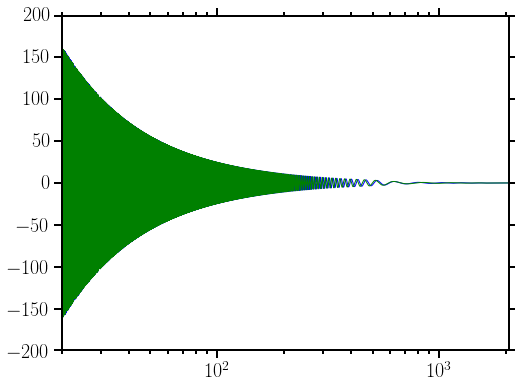

In [52]:
plt.semilogx(h_sur[0], h_sur[1])
plt.semilogx(h_orig[0], h_orig[1])
plt.xlim([20.0, 2048.0]);

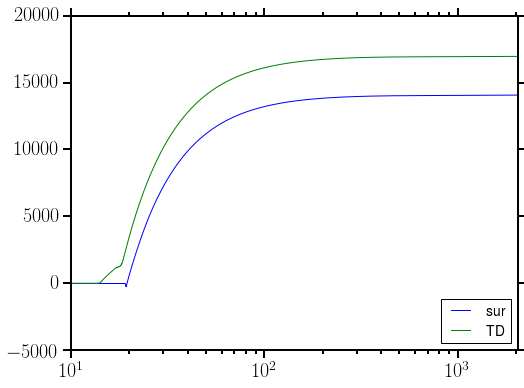

In [40]:
# We see that below 20Hz there are some remnants of the FFT or tapering that we should ignore
plt.semilogx(h_sur[0], np.unwrap(np.angle(h_sur[1])), label='sur')
plt.semilogx(h_orig[0], np.unwrap(np.angle(h_orig[1])), label='TD')
plt.legend(loc=4)
plt.xlim([10.0, 2048.0]);

In [43]:
print len(h_sur[0]), len(h_orig[0])
np.allclose(h_sur[0], h_orig[0])

1048577 1048577


False

In [41]:
np.unique(h_sur[0] - h_orig[0])

array([  0.000000e+00,   5.468750e-04,   1.093750e-03, ...,   5.734389e+02,   5.734395e+02,   5.734400e+02])

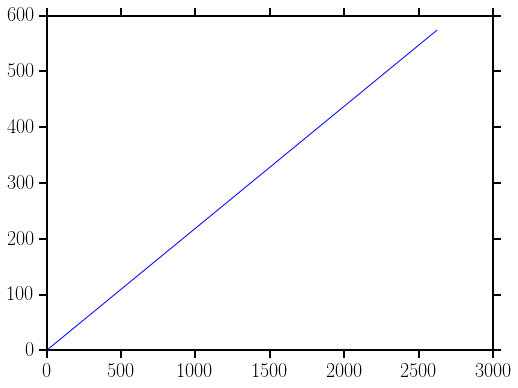

In [45]:
# There is a rather large drift between the frequency vectors
plt.plot(h_sur[0], h_sur[0] - h_orig[0])

In [24]:
f_sur = h_sur[0]
phi_sur = np.unwrap(np.angle(h_sur[1]))
phi_orig = np.unwrap(np.angle(h_orig[1]))

In [30]:
np.unique(np.diff(f_sur))

array([ 0.003906])

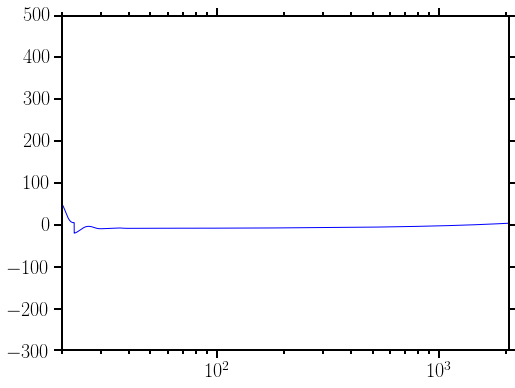

In [65]:
plt.semilogx(h_sur[0], phi_sur - phi_orig + 410)
plt.xlim([20.0, 2048.0]);

Somehow the connectionis not really smooth in the phase
  - overall it looks correct, but here it looks like the sign is wrong and that there is a phase offset (how is that determined)?
  - the obvious first thing to look at is where this transition happens (is it at the transition in the model) and to dump the amplitude and phase data from the C code for debugging
    - this starts at 20Hz and there is no contribution from the low frequency part
    - the first point is 0.000252989: 3252.12 -1169.97
  - the phases aren't completely unwrapped, so we would need a finer deltaF to guarantee this
  - check whether there is anything weird in the surrogate phasing or the TF2 phasing

In [13]:
0.000252989 / (Mtot*lal.MTSUN_SI)

19.02340886293442

In [14]:
0.000253041 / (Mtot*lal.MTSUN_SI)

19.027318982587342

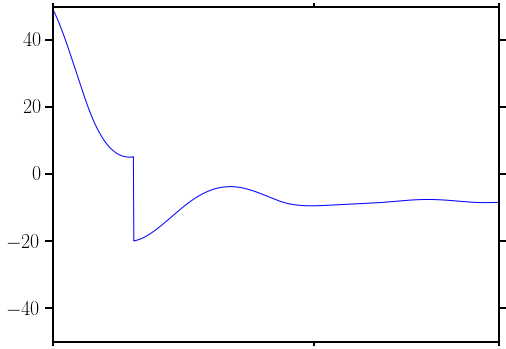

In [22]:
plt.semilogx(h_sur[0], phi_sur - phi_orig + 410)
plt.xlim([20.0, 40.0]);
plt.ylim([-50,50]);

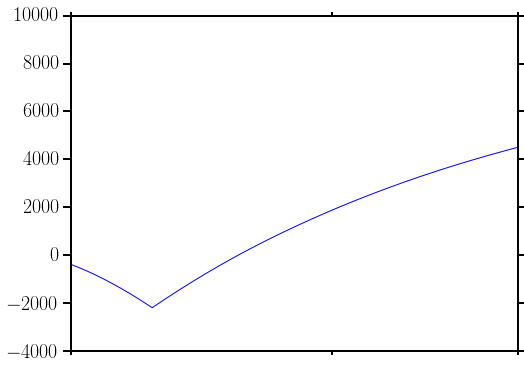

In [28]:
plt.semilogx(f_sur, phi_sur - 0*f_sur)
plt.xlim([20.0, 40.0]);
# plt.ylim([-50,50]);

The issues above have now been fixed by using finer grids for TaylorF2.

## Lower f_min a bit more and don't specify deltaF for SimInspiralFD

### f_min=15Hz TODO

In [29]:
Mtot = 2*1.35

In [30]:
x = np.array([1.0/1.5, 0.35, 0.32, 5000.0, 5000.0])

In [31]:
h_sur = FD_waveform_generate(Mtot, x, LS.SEOBNRv4T_surrogate, fLow=15.0, fHigh=2048.0, deltaF=0)
1./np.diff(h_sur[0])[0]

512.0

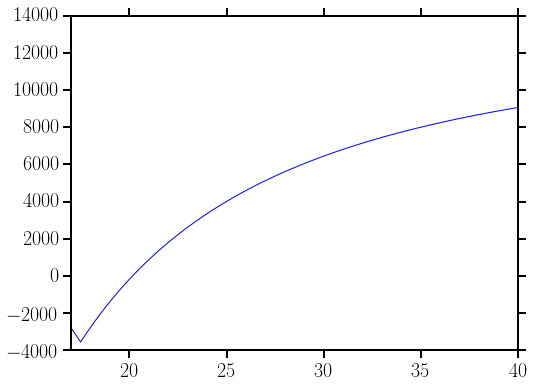

In [32]:
phi_sur = np.unwrap(np.angle(h_sur[1]))
plt.plot(h_sur[0], phi_sur)
plt.xlim([17.0, 40.0]);

In [33]:
# This takes ~ half an hour
h_orig = FD_waveform_generate(Mtot, x, LS.SEOBNRv4T, fLow=15.0, fHigh=2048.0, deltaF=0)

In [34]:
np.save('h_sur_15Hz.npy', h_sur)
np.save('h_orig_15Hz.npy', h_orig)

In [11]:
h_orig = np.load('h_orig_15Hz.npy')

In [35]:
# Takes about 10 minutes to compute
match(h_sur[0], h_sur[1], h_orig[0], h_orig[1], LS.SimNoisePSDaLIGOZeroDetHighPower, zpf=2)

0.9991901345707751

In [36]:
# zero out the data below 20Hz
i20 = np.where(h_sur[0] > 20.0)[0][0]
h_sur_z = h_sur[1].copy()
h_orig_z = h_orig[1].copy()
h_sur_z[:i20] = 0.0
h_orig_z[:i20] = 0.0
match(h_sur[0], h_sur_z, h_orig[0], h_orig_z, LS.SimNoisePSDaLIGOZeroDetHighPower, zpf=2)

0.9992224421971467

In [37]:
phi_sur = np.unwrap(np.angle(h_sur[1]))
phi_orig = np.unwrap(np.angle(h_orig[1]))

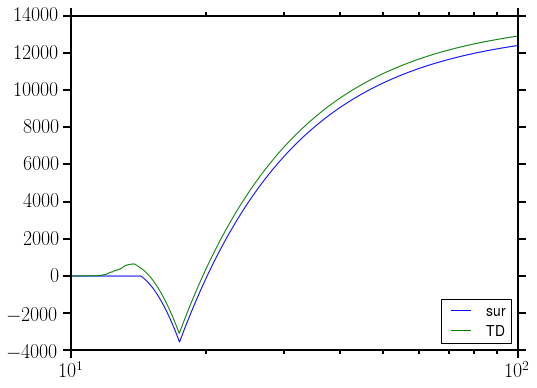

In [38]:
# We see that below 20Hz there are some remnants of the FFT or tapering that we should ignore
plt.semilogx(h_sur[0], phi_sur, label='sur')
plt.semilogx(h_orig[0], phi_orig, label='TD')
plt.legend(loc=4)
plt.xlim([10.0, 100.0]);

In [39]:
# The frequency grids are identical
print len(h_sur[0]), len(h_orig[0])
print np.allclose(h_sur[0], h_orig[0])
np.unique(h_sur[0] - h_orig[0])

1048577 1048577
True


array([0.])

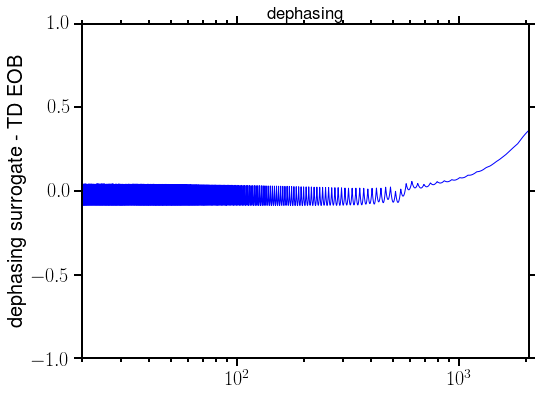

In [53]:
plt.semilogx(h_sur[0], phi_sur - phi_orig + 506.3 - 0.0063*h_sur[0])
plt.xlim([20.0, 2048.0]);
plt.ylim([-1, 1]);
plt.title('dephasing');
plt.ylabel('dephasing surrogate - TD EOB');

Try subtracting TF2 and a time and phase shift

In [41]:
h_TF2 = FD_waveform_generate(Mtot, x, LS.TaylorF2, fLow=15.0, fHigh=2048.0, deltaF=0)

In [42]:
phi_sur = np.unwrap(np.angle(h_sur[1]))
phi_TF2 = np.unwrap(np.angle(h_TF2[1]))

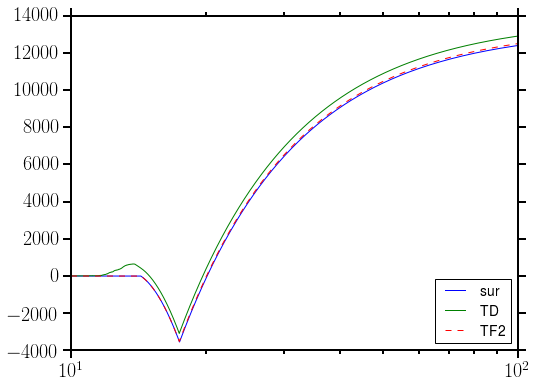

In [43]:
# We see that below 20Hz there are some remnants of the FFT or tapering that we should ignore
plt.semilogx(h_sur[0], phi_sur, label='sur')
plt.semilogx(h_orig[0], phi_orig, label='TD')
plt.semilogx(h_orig[0], phi_TF2, 'r--', label='TF2')
plt.legend(loc=4)
plt.xlim([10.0, 100.0]);

In [44]:
# grab the surrogate phase correction dumped by the C code
sur_phi_at_nodes = np.loadtxt('sur_phi_at_nodes.txt')

In [45]:
phi_sur = np.unwrap(np.angle(h_sur[1]))

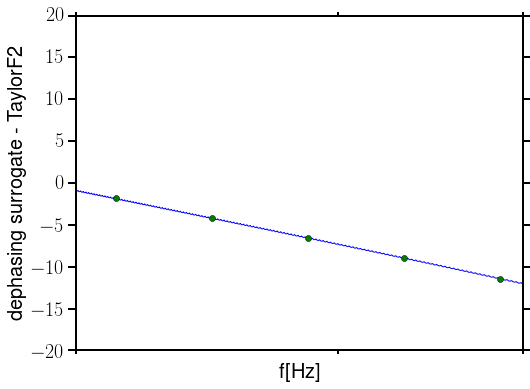

In [61]:
plt.semilogx(h_sur[0], phi_sur - phi_TF2 + 70)
dphiI = spline(h_sur[0], phi_sur - phi_TF2)
plt.semilogx(sur_phi_at_nodes.T[0] / (Mtot*lal.MTSUN_SI), 
             dphiI(sur_phi_at_nodes.T[0] / (Mtot*lal.MTSUN_SI)) + 70, 'o')
plt.xlim([20.0, 40.0]);
plt.ylim([-20, 20]);
plt.xlabel('f[Hz]')
plt.ylabel('dephasing surrogate - TaylorF2');

### f_min=20Hz

In [17]:
Mtot = 2*1.35
fLow = 20.0

In [18]:
x = np.array([1.0/1.5, 0.35, 0.32, 5000.0, 5000.0])

In [19]:
h_sur = FD_waveform_generate(Mtot, x, LS.SEOBNRv4T_surrogate, fLow=fLow, fHigh=2048.0, deltaF=0)
1./np.diff(h_sur[0])[0]

256.0

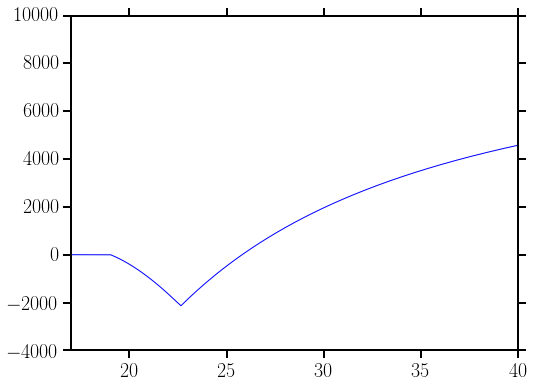

In [20]:
phi_sur = np.unwrap(np.angle(h_sur[1]))
plt.plot(h_sur[0], phi_sur)
plt.xlim([17.0, 40.0]);

In [21]:
# This takes ~ half an hour
h_orig = FD_waveform_generate(Mtot, x, LS.SEOBNRv4T, fLow=fLow, fHigh=2048.0, deltaF=0)

In [22]:
np.save('h_sur_%dHz.npy'%fLow, h_sur)
np.save('h_orig_%dHz.npy'%fLow, h_orig)

In [11]:
h_orig = np.load('h_orig_%dHz.npy'%fLow)

In [23]:
# Takes about 10 minutes to compute
match(h_sur[0], h_sur[1], h_orig[0], h_orig[1], LS.SimNoisePSDaLIGOZeroDetHighPower, zpf=2)

0.998997615527789

In [24]:
# zero out the data below 20Hz
i20 = np.where(h_sur[0] > 20.0)[0][0]
h_sur_z = h_sur[1].copy()
h_orig_z = h_orig[1].copy()
h_sur_z[:i20] = 0.0
h_orig_z[:i20] = 0.0
match(h_sur[0], h_sur_z, h_orig[0], h_orig_z, LS.SimNoisePSDaLIGOZeroDetHighPower, zpf=2)

0.9991098098636902

In [25]:
phi_sur = np.unwrap(np.angle(h_sur[1]))
phi_orig = np.unwrap(np.angle(h_orig[1]))

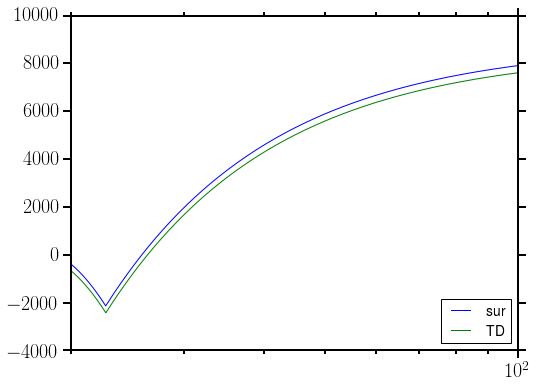

In [26]:
# We see that below 20Hz there are some remnants of the FFT or tapering that we should ignore
plt.semilogx(h_sur[0], phi_sur, label='sur')
plt.semilogx(h_orig[0], phi_orig, label='TD')
plt.legend(loc=4)
plt.xlim([20.0, 100.0]);

In [27]:
# The frequency grids are identical
print len(h_sur[0]), len(h_orig[0])
print np.allclose(h_sur[0], h_orig[0])
np.unique(h_sur[0] - h_orig[0])

524289 524289
True


array([0.])

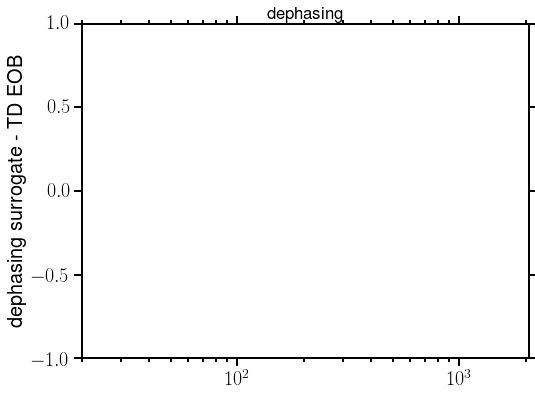

In [28]:
plt.semilogx(h_sur[0], phi_sur - phi_orig + 2757.1 - 0.0063*h_sur[0])
plt.xlim([20.0, 2048.0]);
plt.ylim([-1, 1]);
plt.title('dephasing');
plt.ylabel('dephasing surrogate - TD EOB');

# Debugging intermediate LAL code outputs

Use helper function to write amplitude and phase data for surrogate, TaylorF2, and their combination to disk.

```
print_gsl_frequency_series("sur_amp_at_nodes.txt", sur->mf_amp, sur_amp_at_nodes);
print_gsl_frequency_series("sur_phi_at_nodes.txt", sur->mf_amp, sur_phi_at_nodes);

print_gsl_frequency_series("TF2_amp_at_nodes.txt", sur->TF2_mf_amp, TF2_amp_at_nodes);
print_gsl_frequency_series("TF2_phi_at_nodes.txt", sur->TF2_mf_phi, TF2_phi_at_nodes);

print_gsl_frequency_series("amp_at_nodes.txt", sur->TF2_mf_amp, spline_amp_values);
print_gsl_frequency_series("phi_at_nodes.txt", sur->TF2_mf_phi, spline_phi_values);
```

```
print_gsl_frequency_series: sur_amp_at_nodes.txt: 40 40
print_gsl_frequency_series: sur_phi_at_nodes.txt: 40 40
print_gsl_frequency_series: TF2_amp_at_nodes.txt: 102 102
print_gsl_frequency_series: TF2_phi_at_nodes.txt: 307 307
print_gsl_frequency_series: amp_at_nodes.txt: 102 102
print_gsl_frequency_series: phi_at_nodes.txt: 307 307
```

In [50]:
sur_amp_at_nodes = np.loadtxt('sur_amp_at_nodes.txt').T
sur_phi_at_nodes = np.loadtxt('sur_phi_at_nodes.txt').T
TF2_amp_at_nodes = np.loadtxt('TF2_amp_at_nodes.txt').T
TF2_phi_at_nodes = np.loadtxt('TF2_phi_at_nodes.txt').T
amp_at_nodes = np.loadtxt('amp_at_nodes.txt').T
phi_at_nodes = np.loadtxt('phi_at_nodes.txt').T

The last point in the green plot can be ignored. We never evaluate the splines there.

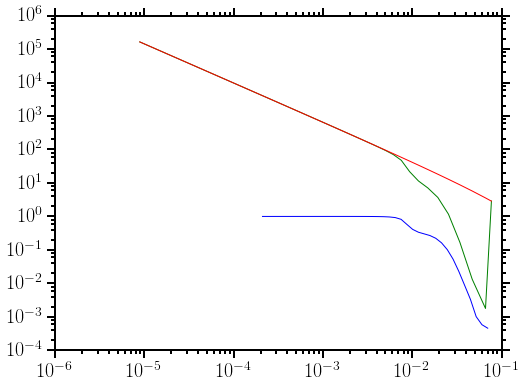

In [54]:
plt.loglog(sur_amp_at_nodes[0], np.exp(sur_amp_at_nodes[1]))
plt.loglog(amp_at_nodes[0], amp_at_nodes[1])
plt.loglog(TF2_amp_at_nodes[0], TF2_amp_at_nodes[1]);

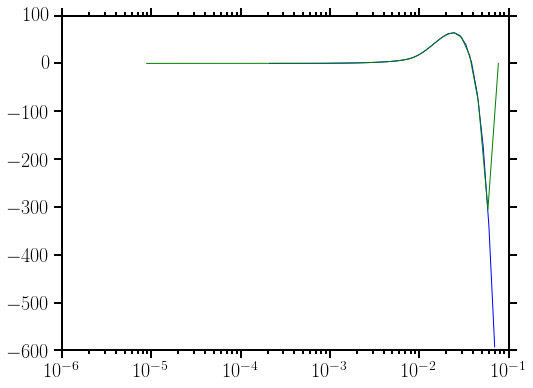

In [53]:
plt.semilogx(sur_phi_at_nodes[0], sur_phi_at_nodes[1])
plt.semilogx(TF2_phi_at_nodes[0], phi_at_nodes[1] - TF2_phi_at_nodes[1]);

# Compare surrogate with linear and cubic spline order

Test accuracy and speed between linear and cubic splines for TF2.

## Functions

In [133]:
def FD_waveform_generate_direct(Mtot, x, fLow=20.0, fHigh=2048.0, 
                                deltaF=0.1, spline_order=3):
    q = 1.0/x[0]
    chi1 = x[1]
    chi2 = x[2]
    lambda1 = x[3]
    lambda2 = x[4]
    
    phiRef, fRef = 0.0, fLow
    distance, inclination = 1.0, 0.0
    
    m1 = q/(1.0+q)*Mtot
    m2 = 1.0/(1.0+q)*Mtot
    m1SI, m2SI, chi1, chi2, lambda1, lambda2 = m1*lal.MSUN_SI, m2*lal.MSUN_SI, chi1, chi2, lambda1, lambda2
    
    if (spline_order == 1):
        gsl_spline_order = LS.SEOBNRv4TSurrogate_LINEAR
    elif (spline_order == 3):
        gsl_spline_order = LS.SEOBNRv4TSurrogate_CUBIC
    else:
        raise Error
    
    hp, hc = LS.SimIMRSEOBNRv4TSurrogate(phiRef, deltaF, 
                            fLow, fHigh, fRef, 
                            distance, inclination, 
                            m1SI, m2SI, 
                            chi1, chi2,
                            lambda1, lambda2,
                            gsl_spline_order)
    
    fHz = np.arange(hp.data.length)*hp.deltaF
    h = hp.data.data + 1j*hc.data.data
    
    return fHz, h

In [134]:
def FD_waveform_generate(Mtot, x, approximant, fLow=20.0, fHigh=2048.0, deltaF=0):
    q = 1.0/x[0]
    chi1 = x[1]
    chi2 = x[2]
    lambda1 = x[3]
    lambda2 = x[4]
    
    phiRef, fRef = 0.0, fLow
    distance, inclination = 1.0, 0.0
    
    m1 = q/(1.0+q)*Mtot
    m2 = 1.0/(1.0+q)*Mtot
    m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max = m1*lal.MSUN_SI, m2*lal.MSUN_SI, chi1, chi2, lambda1, lambda2, -1

    longAscNodes, eccentricity, meanPerAno = 0,0,0

    LALpars = lal.CreateDict()
    lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1(LALpars, lambda1)
    lalsimulation.SimInspiralWaveformParamsInsertTidalLambda2(LALpars, lambda2)

    # Nyquist frequency is set by fHigh
    # Can set deltaF = 0 to figure out required frequency spacing; the chosen deltaF depends on fLow
    
    # Documentation from LALSimInspiral.c
    #
    #  * This routine can generate TD approximants and transform them into the frequency domain.
    #  * Waveforms are generated beginning at a slightly lower starting frequency and tapers
    #  * are put in this early region so that the waveform smoothly turns on.
    #  *
    #  * If an FD approximant is used, this routine applies tapers in the frequency domain
    #  * between the slightly-lower frequency and the requested f_min.  Also, the phase of the
    #  * waveform is adjusted to introduce a time shift.  This time shift should allow the
    #  * resulting waveform to be Fourier transformed into the time domain without wrapping
    #  * the end of the waveform to the beginning.
    #  *
    #  * This routine assumes that f_max is the Nyquist frequency of a corresponding time-domain
    #  * waveform, so that deltaT = 0.5 / f_max.  If deltaF is set to 0 then this routine computes
    #  * a deltaF that is small enough to represent the Fourier transform of a time-domain waveform.
    #  * If deltaF is specified but f_max / deltaF is not a power of 2, and the waveform approximant
    #  * is a time-domain approximant, then f_max is increased so that f_max / deltaF is the next
    #  * power of 2.  (If the user wishes to discard the extra high frequency content, this must
    #  * be done separately.)
    
    hp, hc = LS.SimInspiralFD(m1SI, m2SI,
                     0.0, 0.0, chi1,
                     0.0, 0.0, chi2,
                     distance, inclination, phiRef, 
                     longAscNodes, eccentricity, meanPerAno, 
                     deltaF,
                     fLow, fHigh, fRef,
                     LALpars,
                     approximant)

    fHz = np.arange(hp.data.length)*hp.deltaF
    h = hp.data.data + 1j*hc.data.data
    
    return fHz, h

In [135]:
def match(f1, h1, f2, h2, psdfun, zpf=5):
    """
    Compute the match between FD waveforms h1, h2

    :param h1, h2: COMPLEX16FrequencySeries
    :param psdfun: power spectral density as a function of frequency in Hz
    :param zpf:    zero-padding factor
    """
    assert(len(h1) == len(h2))
    assert(np.allclose(f1, f2))
    f = f1
    n = len(h1)
    psd_ratio = psdfun(100) / np.array(map(psdfun, f))
    psd_ratio[0] = psd_ratio[1] # get rid of psdfun(0) = nan
    h1abs = np.abs(h1)
    h2abs = np.abs(h2)
    norm1 = np.dot(h1abs, h1abs*psd_ratio)
    norm2 = np.dot(h2abs, h2abs*psd_ratio)
    integrand = h1 * h2.conj() * psd_ratio
    integrand_zp = np.lib.pad(integrand, n*zpf, 'constant', constant_values=0) # zeropad it
    #integrand_zp = np.concatenate([np.zeros(n*zpf), integrand, np.zeros(n*zpf)]) # zeropad it, in case we don't have np.lib.pad
    csnr = np.asarray(np.fft.fft(integrand_zp)) # complex snr; numpy.fft = Mma iFFT with our conventions
    return np.max(np.abs(csnr)) / np.sqrt(norm1*norm2)

In [136]:
def check_match_spline_order(Mtot, x, fLow=15.0, fHigh=2048.0, zpf=2, df=0.1):
    if df == 0:
        # Set df from LALSimInspiralFD
        f, h = FD_waveform_generate(Mtot, x, LS.SEOBNRv4T_surrogate, 
                                    fLow=fLow, fHigh=fHigh, deltaF=df)
        df = np.unique(np.diff(f))[0]
        print 'Using Deltaf, 1/Deltaf:', df, 1./df
        
    f1, h1 = FD_waveform_generate_direct(Mtot, x, 
                                         fLow=fLow, fHigh=fHigh, deltaF=df,
                                         spline_order=1)
    f3, h3 = FD_waveform_generate_direct(Mtot, x,
                                         fLow=fLow, fHigh=fHigh, deltaF=df,
                                         spline_order=3)
    return f1, h1, f3, h3, match(f1, h1, f3, h3, 
                                 LS.SimNoisePSDaLIGOZeroDetHighPower, zpf=zpf)

## Test accuracy

Accuracy looks good even for very long waveforms with a proper Nyquist grid.

In [138]:
Mtot = 2*1.35
x = np.array([1.0/1.5, 0.35, 0.32, 5000.0, 5000.0])
_, _, _, _, ma = check_match_spline_order(Mtot, x, fLow=15.0, fHigh=2048.0, zpf=1, df=0.1)
print ma

0.9993626617630912


In [139]:
Mtot = 2*1.35
x = np.array([1.0/1.5, 0.35, 0.32, 5000.0, 5000.0])
_, _, _, _, ma = check_match_spline_order(Mtot, x, fLow=15.0, fHigh=2048.0, zpf=1, df=0.01)
print ma

0.9992606648965577


Computing the match is memory bound and **very slow!** on my laptop.

In [140]:
Mtot = 2*1.35
x = np.array([1.0/1.5, 0.35, 0.32, 5000.0, 5000.0])
_, _, _, _, ma = check_match_spline_order(Mtot, x, fLow=15.0, fHigh=2048.0, zpf=1, df=0.005)
print ma

0.7580439282662002


In [12]:
Mtot = 2*1.35
x = np.array([1.0/1.5, 0.35, 0.32, 5000.0, 5000.0])
_, _, _, _, ma = check_match_spline_order(Mtot, x, fLow=15.0, fHigh=2048.0, zpf=1, df=0)
print ma

Using Deltaf, 1/Deltaf: 0.001953125 512.0
0.999154395724


## Test speed

We see that the linear spline version is about 15% faster (using the current number of points).

In [15]:
Mtot = 2*1.35
x = np.array([1.0/1.5, 0.35, 0.32, 5000.0, 5000.0])

fLow = 10.0
fHigh = 2048.0
df = 0.01

In [16]:
%%timeit 

FD_waveform_generate_direct(Mtot, x, 
                            fLow=fLow, fHigh=fHigh, deltaF=df,
                            spline_order=1)

10 loops, best of 3: 30.6 ms per loop


In [17]:
%%timeit 

FD_waveform_generate_direct(Mtot, x, 
                            fLow=fLow, fHigh=fHigh, deltaF=df,
                            spline_order=3)

10 loops, best of 3: 34.9 ms per loop


In [43]:
fLow = 10.0
df = 1. / LS.SimInspiralTaylorF2ReducedSpinChirpTime(fLow, Mtot/2.*lal.MSUN_SI, Mtot/2.*lal.MSUN_SI, 0, -1)
print df

0.000926615211479


In [41]:
%%timeit

FD_waveform_generate_direct(Mtot, x, 
                            fLow=fLow, fHigh=fHigh, deltaF=df,
                            spline_order=1)

1 loop, best of 3: 295 ms per loop


In [42]:
%%timeit 

FD_waveform_generate_direct(Mtot, x, 
                            fLow=fLow, fHigh=fHigh, deltaF=df,
                            spline_order=3)

1 loop, best of 3: 326 ms per loop


In [44]:
fLow = 5.0
df = 1. / LS.SimInspiralTaylorF2ReducedSpinChirpTime(fLow, Mtot/2.*lal.MSUN_SI, Mtot/2.*lal.MSUN_SI, 0, -1)
print df

0.000146486403333


In [45]:
%%timeit

FD_waveform_generate_direct(Mtot, x, 
                            fLow=fLow, fHigh=fHigh, deltaF=df,
                            spline_order=1)

1 loop, best of 3: 1.79 s per loop


In [46]:
%%timeit 

FD_waveform_generate_direct(Mtot, x, 
                            fLow=fLow, fHigh=fHigh, deltaF=df,
                            spline_order=3)

1 loop, best of 3: 2.06 s per loop


This is very heavily memory bound.

In [47]:
fLow = 2.0
df = 1. / LS.SimInspiralTaylorF2ReducedSpinChirpTime(fLow, Mtot/2.*lal.MSUN_SI, Mtot/2.*lal.MSUN_SI, 0, -1)
print df

1.27712033902e-05


In [48]:
%%timeit

FD_waveform_generate_direct(Mtot, x, 
                            fLow=fLow, fHigh=fHigh, deltaF=df,
                            spline_order=1)

1 loop, best of 3: 42.7 s per loop


In [49]:
%%timeit 

FD_waveform_generate_direct(Mtot, x, 
                            fLow=fLow, fHigh=fHigh, deltaF=df,
                            spline_order=3)

1 loop, best of 3: 42.4 s per loop


## iprofiler

### compiled with cubic spline

In [51]:
%%bash
iprofiler -timeprofiler -activitymonitor -leaks \
/Users/mpuer/master/bin/lalsim-inspiral \
-a SEOBNRv4T_surrogate --spin2z 0.4 --tidal-lambda1 5000.0 --m1 1.4 --m2 1.35 --f-min 10 > out

<img src="trace_cspline_BNS.png">

### compiled with linear spline

Compared to the cubic spline code `gsl_interp_eval` is down from 18% to 8.7%.

In [4]:
%%bash
iprofiler -timeprofiler -activitymonitor -leaks \
/Users/mpuer/master/bin/lalsim-inspiral \
-a SEOBNRv4T_surrogate --spin2z 0.4 --tidal-lambda1 5000.0 --m1 1.4 --m2 1.35 --f-min 10 > out

<img src="trace_lspline_BNS.png">

# TODOs

TODO:
  * set up a parallel generation script for TEOBv4 waveforms on vulcan (use 18Hz, 8Hz) for BNS